In [66]:
import typing
import pandas as pd
import numpy as np
from glob import glob
# from ts_helper_functions1 import *
import matplotlib.pyplot as plt
import seaborn as sns
import datarobot as dr
import datarobot_ts_helpers as ts
import jiffypy 


# set pandas configuration to show all columns
pd.set_option('display.max_columns', None)

In [67]:
# import some functons directly, don't want to deal with circular logic right now

def check_gap(df: pd.core.frame.DataFrame
              , ts_settings: dict
             ):
    '''
    Determine spacing of time-steps from dataframe
    '''
    median_gap = int(df[ts_settings['date_col']].diff().median().days)
    if median_gap == 1:
        freq = 'days'
    elif median_gap == 7:
        freq= 'weeks'
    elif median_gap == 30:
        freq= 'months'
    else:
        return 'Cannot parse the time-step from the provided data. Please provide the frequency explicitly'
    return freq


def check_fdw(df: pd.core.frame.DataFrame
              , fp: str, ts_settings: dict
              , freq: typing.Optional['str']= None
             ):
    '''
    Check if sufficient FDW data is present.
    '''
    if freq is None:
        freq= check_gap(df, ts_settings)
    fdw_date = fp + pd.DateOffset(ts_settings['fdw_start'], freq)
    if fdw_date in df[ts_settings['date_col']].unique():
        return fdw_date
    else:
        return False

    
def check_columns(df1: pd.core.frame.DataFrame
                  , df2: pd.core.frame.DataFrame
                 ):
    '''
    Compare two dataframes to see if columns match
    '''
    if all(df1.columns == df2.columns):
        return True
    elif len(list(set(df1.columns).difference(set(df2.columns)))) == 0:
        return 'Sort'
    else:
        return list(set(df1.columns).difference(set(df2.columns)))


----
# Minor update to do (low priority):
- Update existing ts_helper_functions to use typing.Optional syntax instead of False for optional variables

In [6]:
pwd = !pwd
pwd = pwd[0]
pwd = pwd.rstrip('/src')+'/data/*'
files = glob(pwd)
files

[]

In [7]:
path = '/Users/jarredbultema/repos/jiffyscience/users/jarredbultema/demand_forecasting_cst/data/Order and Ticket Count + Sales - 2016 to 5_5_21.xlsx'
df = pd.read_excel(path, sheet_name= 'Daily', parse_dates= ['Date'])
df.head()

<ipython-input-7-66c59c59ae65>:2: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  df = pd.read_excel(path, sheet_name= 'Daily', parse_dates= ['Date'])


,Date,Day,Orders,CST Tickets,All Tickets,Unique Requesters,Average Time/CST Ticket,Revenue,Tax,Shipping,Net,Week,Orders/Week,CST Tickets/Week,All Tickets/Week,Unique Requesters/Week,Avg Time/Ticket/Week,Net/Week
0,2016-01-01,NaN,251,12.0,42,8,2398.333333,23400.05,0.0,734.60,22665.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-02,NaN,288,15.0,52,12,508.733333,23513.11,0.0,1092.10,22421.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-03,NaN,327,35.0,62,18,241.485714,16849.05,0.0,905.65,15943.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-04,1.0,845,47.0,299,96,435.659574,59523.53,0.0,2210.35,57313.18,1.0,4215.0,564.0,1683.0,535.0,274.882979,384785.07
4,2016-01-05,2.0,707,150.0,260,78,288.700000,78214.64,0.0,2053.60,76161.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# there is a problem with the 'week' column in this dataset that introduces a bunch of nans
# I don't care about most of them, but will use 'week' as a test to see if nan are introduced
df['Week'] = df['Date'].dt.week


<ipython-input-8-4915da07ab71>:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['Week'] = df['Date'].dt.week


In [12]:
# test dataset, AB_variant_daily_agg_pre_TS_prep
df_weekly = pd.read_csv('/Users/jarredbultema/repos/jiffyscience/users/jarredbultema/demand_forecasting_alpha_broder/src/weekly_variant_region_pre_TS_tool.csv', parse_dates=['date'])
df_daily = pd.read_csv('/Users/jarredbultema/repos/jiffyscience/users/jarredbultema/demand_forecasting_alpha_broder/src/daily_agg_variant_group_region_pre_TS_prep.csv', parse_dates=['date'])

In [13]:
df_weekly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3886059 entries, 0 to 3886058
Data columns (total 10 columns):
 #   Column             Dtype         
---  ------             -----         
 0   date               datetime64[ns]
 1   variant_id_region  object        
 2   avg_list_price     float64       
 3   avg_sold_price     float64       
 4   num_orders         int64         
 5   avg_volume         int64         
 6   min_volume         int64         
 7   max_volume         int64         
 8   total_volume       int64         
 9   total_revenue      float64       
dtypes: datetime64[ns](1), float64(3), int64(5), object(1)
memory usage: 296.5+ MB


In [14]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1829320 entries, 0 to 1829319
Data columns (total 16 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   date                     datetime64[ns]
 1   region                   object        
 2   variant_group_id         int64         
 3   avg_list_price           float64       
 4   avg_sold_price           float64       
 5   num_orders               int64         
 6   avg_volume               int64         
 7   min_volume               int64         
 8   max_volume               int64         
 9   total_volume             int64         
 10  total_revenue            float64       
 11  variant_group_id_region  object        
 12  product_id               int64         
 13  brand_family             object        
 14  brand_name               object        
 15  catalog_number           object        
dtypes: datetime64[ns](1), float64(3), int64(7), object(5)
memory usage: 223.

------
# Create settings dictionaries for the different testing datasets

In [15]:
df.head(2)

,Date,Day,Orders,CST Tickets,All Tickets,Unique Requesters,Average Time/CST Ticket,Revenue,Tax,Shipping,Net,Week,Orders/Week,CST Tickets/Week,All Tickets/Week,Unique Requesters/Week,Avg Time/Ticket/Week,Net/Week
0,2016-01-01,NaN,251,12.0,42,8,2398.333333,23400.05,0.0,734.6,22665.45,53,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-02,NaN,288,15.0,52,12,508.733333,23513.11,0.0,1092.1,22421.01,53,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
# Set default values
target= 'CST Tickets'
date_col = 'Date'
series_id = None
kia = ['Day', 'Week'] # No columns known in advance
dnd= None # define the DND variables here as a list of column-name-strings or leave as None
num_backtests = 3
validation_duration = 30 # want to predict 1-month sales, validating on the same period
holdout_duration = 30 
disable_holdout = False
metric = 'RMSE' # see discussion on metrics below, using 'RMSE' for simplicity
use_time_series = True
use_cross_series_features = False
fd_start = 1
fd_end = 7 # forecasting sales for the next month
fdw_start = -28 
fdw_end = 0
max_date = df['Date'].max()
mode= dr.AUTOPILOT_MODE.QUICK # set the modeling mode
n_workers= -1 # you can limit the workers used per project (int) or use all (-1). I typically use 5-20 workers/project, but not all

# create Time Series settings
CST_settings = {'max_date':max_date, 'known_in_advance':kia, 'do_not_derive': dnd,
                'use_cross_series_features': use_cross_series_features,
               'num_backtests':num_backtests, 'validation_duration':validation_duration, 
               'holdout_duration':holdout_duration,'disable_holdout':disable_holdout,'use_time_series':use_time_series,
               'series_id':series_id, 'metric':metric, 'target':target, 'date_col':date_col,
               'fd_start':fd_start, 'fd_end':fd_end, 'fdw_start':fdw_start, 'fdw_end':fdw_end,
               'n_workers': n_workers, 'mode': mode}

In [17]:
pwd

'/Users/jarredbultema/repos/jiffyscience/users/jarredbultema/jiffy_ts_helpe/data/*'

In [18]:
# Set default values
target= 'total_volume'
date_col = 'date'
series_id = 'variant_group_id_region'
kia = ['region', 'variant_group_id', 'product_id', 'brand_family', 'brand_name', 'catalog_number'] # No columns known in advance
dnd= None # define the DND variables here as a list of column-name-strings or leave as None
num_backtests = 3
validation_duration = 30 # want to predict 1-month sales, validating on the same period
holdout_duration = 30 
disable_holdout = False
metric = 'RMSE' # see discussion on metrics below, using 'RMSE' for simplicity
use_time_series = True
use_cross_series_features = False
fd_start = 1
fd_end = 7 # forecasting sales for the next month
fdw_start = -28 
fdw_end = 0
max_date = df_daily['date'].max()
mode= dr.AUTOPILOT_MODE.QUICK # set the modeling mode
n_workers= -1 # you can limit the workers used per project (int) or use all (-1). I typically use 5-20 workers/project, but not all

# create Time Series settings
daily_settings = {'max_date':max_date, 'known_in_advance':kia, 'do_not_derive': dnd,
                'use_cross_series_features': use_cross_series_features,
               'num_backtests':num_backtests, 'validation_duration':validation_duration, 
               'holdout_duration':holdout_duration,'disable_holdout':disable_holdout,'use_time_series':use_time_series,
               'series_id':series_id, 'metric':metric, 'target':target, 'date_col':date_col,
               'fd_start':fd_start, 'fd_end':fd_end, 'fdw_start':fdw_start, 'fdw_end':fdw_end,
               'n_workers': n_workers, 'mode': mode}

In [19]:
df_weekly.head(2)

,date,variant_id_region,avg_list_price,avg_sold_price,num_orders,avg_volume,min_volume,max_volume,total_volume,total_revenue
0,2015-12-28,18039-midwest,8.29,8.29,2,1,1,1,2,16.58
1,2015-12-28,18058-texas,9.93,9.93,2,1,1,1,2,19.86


In [20]:
# Set default values
target= 'total_volume'
date_col = 'date'
series_id = 'variant_id_region'
kia = None # No columns known in advance
dnd= None # define the DND variables here as a list of column-name-strings or leave as None
num_backtests = 3
validation_duration = 30 # want to predict 1-month sales, validating on the same period
holdout_duration = 30 
disable_holdout = False
metric = 'RMSE' # see discussion on metrics below, using 'RMSE' for simplicity
use_time_series = True
use_cross_series_features = False
fd_start = 1
fd_end = 7 # forecasting sales for the next month
fdw_start = -28 
fdw_end = 0
max_date = df_weekly['date'].max()
mode= dr.AUTOPILOT_MODE.QUICK # set the modeling mode
n_workers= -1 # you can limit the workers used per project (int) or use all (-1). I typically use 5-20 workers/project, but not all

# create Time Series settings
weekly_settings = {'max_date':max_date, 'known_in_advance':kia, 'do_not_derive': dnd,
                'use_cross_series_features': use_cross_series_features,
               'num_backtests':num_backtests, 'validation_duration':validation_duration, 
               'holdout_duration':holdout_duration,'disable_holdout':disable_holdout,'use_time_series':use_time_series,
               'series_id':series_id, 'metric':metric, 'target':target, 'date_col':date_col,
               'fd_start':fd_start, 'fd_end':fd_end, 'fdw_start':fdw_start, 'fdw_end':fdw_end,
               'n_workers': n_workers, 'mode': mode}

------
# Updates to create_splits to work with dictionary

In [101]:
from tqdm import tqdm

def calc_summary_stats(df: pd.core.frame.DataFrame,
                       ts_settings: dict
                       
) -> dict:
    """
    Analyze time series data to perform checks and gather summary statistics prior to modeling.
    
    Inputs:
    ------
    df: Pandas dataframe with training data
    ts_settings: dictionary of modeling settings
    
    Ouput:
    ------
    stats: Dictionary with various statistics on the dataframe
    """
    # define convenience variables
    date_col = ts_settings['date_col']
    target = ts_settings['target']
    series_id = ts_settings['series_id']

    # force datetime conversion as a precaution
    df[date_col] = pd.to_datetime(df[date_col])
    
    if series_id:
        df.sort_values(by=[date_col, series_id], ascending=True, inplace=True)
    else:
        df.sort_values(by=[date_col], ascending=True, inplace=True)

    # Create dictionary of helpful statistics
    stats = dict()
    stats['date_col'] = date_col
    stats['target'] = target
    stats['series_id'] = series_id
    stats['rows'] = df.shape[0]
    stats['columns'] = df.shape[1]
    stats['min_target'] = df[target].min()
    stats['max_target'] = df[target].max()
    stats['start_date'] = df[date_col].min()
    stats['end_date'] = df[date_col].max()
    stats['timespan'] = stats['end_date'] - stats['start_date']
    
    if series_id:
        stats['series'] = len(df[series_id].unique())
        stats['median_timestep'] = df.groupby([series_id])[date_col].diff().median()
        stats['min_timestep'] = df.groupby([series_id])[date_col].diff().min()
        stats['max_timestep'] = df.groupby([series_id])[date_col].diff().max()
    else:
        stats['median_timestep'] = df[date_col].diff().median()
        stats['min_timestep'] = df[date_col].diff().min()
        stats['max_timestep'] = df[date_col].diff().max()
    
    if series_id:
        # create data for histogram of series lengths
        stats['series_length'] = (
            df.groupby([series_id])[date_col].apply(lambda x: x.max() - x.min())
            / stats['median_timestep']
        )

        # calculate max gap per series
        stats['series_max_gap'] = (
            df.groupby([series_id])[date_col].apply(lambda x: x.diff().max())
            / stats['median_timestep']
        )
    return stats
    
    
def calc_time_steps(df: pd.core.frame.DataFrame,
                    stats: dict
) -> dict:
    """
    Calculate timesteps per series
    
    Inputs:
    ------
    df: Pandas dataframe with training data
    stats: Output of calc_summary_stats function
    
    Ouput:
    ------
    stats: Dictionary with additional statistics on the dataframe
    """
    # calculate the timestep between rows
    if stats['series_id']:
        timesteps = df.groupby([stats['series_id']])[stats['date_col']].diff() / stats['median_timestep']
        stats['series_time_steps'] = timesteps.mean()
        stats['time_step'] = np.nan

    else:
        timesteps = df[stats['date_col']].diff() / stats['median_timestep']
        stats['time_step'] = timesteps.mean()
        stats['series_time_steps'] = np.nan
    
    return stats    
    
    
def create_splits(df: pd.core.frame.DataFrame, 
                  ts_settings: dict,
                  num_validations: int, 
                  training_duration: int, 
                  validation_duration: int, 
                  holdout: bool = True,
                  gap: int = 0, 
                  series_id= False,
                  specific_dates= False,
                  split_pct= False,
                  trim_leading_zeros: bool = True,
                  trim_lagging_zeros: bool = True
) -> dict: 
    '''
    A function to create backtests for partitioning time_series modeling.
    
    Inputs:
    ------
    df: Pandas dataframe with training data
    ts_settings: dictionary of modeling settings
    num_validations: Number of backtests to create (excluding holdout)
    training_duration: Number of rows for the training data
    validation_duration: Number of rows for the validation data
    holdout: Bool, generate holdout with most recent data
    gap: Number of rows between end of training data and start of validation
    specific dates: Bool, or a list of tuples with 
        (training_start, training_stop, validation_start, validation_stop) for each backtest
    split_pct: False or float. Percent of data to be used for training in training/validation-folds
    trim_leading_zeros: controls if zero-target or missing-target values before first real-observation are removed
    trim_leading_zeros: controls if zero-target or missing-target values after last real-observation are removed

        
    Output:
    ------
    df_dict: nested dictionary of Pandas DataFrames. 
        Ex: {'backtest1': {'training': backtest1_training, 'validation': backtest1_validation}}
    '''
    
    # define convenience variables
    date_col = ts_settings['date_col']
    target = ts_settings['target']
    series_id = ts_settings['series_id']
    
    # create the output-dict and intermediate dicts
    df_dict = {}
    training_dict = {}
    validation_dict = {}
    
    # explicitly set datetime format
    # ambiguity in date-formatting often causes problems
    df[date_col] = pd.to_datetime(df[date_col])
    
    # trimming processing
    df_raw = df.copy()
    
    # this needs to be adjusted to work with multi-series data
    # for now, this will work (execute) but not do what you want with multi-series data and give per-series trimming
    if trim_leading_zeros:
        first1 = df[(df[target].notna())][date_col].min()
        first2 = df[(df[target]!= 0)][date_col].min()
        first_real = max(first1, first2)
        df = df[df[date_col] >= first_real].copy()
        print('Leading bad rows removed: ', df_raw.shape[0]-df.shape[0])
        
    if trim_lagging_zeros:
        last_observation = df[(df[target].notna()) | (df[target]!= 0)][date_col].max()
        last1 = df[(df[target].notna())][date_col].max()
        last2 = df[(df[target]!= 0)][date_col].max()
        last_real = min(last1, last2)
        df = df[df[date_col] <= last_real].copy()
        print('Lagging bad rows removed: ', df_raw.shape[0]-df.shape[0])

    # calculate stats on the data
    stats = calc_summary_stats(df, ts_settings)
    stats = calc_time_steps(df, stats)
    df_dict['stats'] = stats
    
    for i in tqdm(range(0, num_validations + holdout), leave= True, desc= 'Creating Backtests'):
        
        # calculate date boundaries
        if i == 0:
            # set dates for first backtest
            max_validation_date = df[date_col].max()
            min_validation_date = pd.to_datetime(max_validation_date - pd.DateOffset(validation_duration))
            max_train_date = pd.to_datetime(min_validation_date - pd.DateOffset(gap) - pd.DateOffset(1))
            min_train_date = pd.to_datetime(max_train_date - pd.DateOffset(training_duration))
            
        else:
            # use the date values from the previous backtest to determine these
            max_validation_date = max_validation_date - pd.DateOffset(validation_duration) - pd.DateOffset(1)
            min_validation_date = pd.to_datetime(max_validation_date - pd.DateOffset(validation_duration))
            max_train_date = pd.to_datetime(min_validation_date - pd.DateOffset(gap) - pd.DateOffset(1))
            min_train_date = pd.to_datetime(max_train_date - pd.DateOffset(training_duration))

        ### split the data ###

        # if using split_pct, perform based on % of total data
        # this option is desired for use with a single backtest for internal hyperparameter tuning
        if split_pct:
            cut_point = pd.to_datetime(df[date_col].max() - pd.DateOffset(int(stats['rows']*(1-split_pct))))
            validation = df[df[date_col] >= cut_point].copy()
            training = df[df[date_col] < cut_point].copy()

        # make the split based on specific values provided as list of tuples
        elif specific_dates:
            backtest_dates = specific_dates[i]
            training = df[(df[date_col] >= pd.to_datetime(backtest_dates[0])) & (df[date_col] <= pd.to_datetime(backtest_dates[1]))].copy()
            validation = df[(df[date_col] >= pd.to_datetime(backtest_dates[2])) & (df[date_col] <= pd.to_datetime(backtest_dates[3]))].copy()

        # make the split based on provided durations
        else:
            validation = df[(df[date_col] >= min_validation_date) & (df[date_col] <= max_validation_date)].copy()
            training = df[(df[date_col] >= min_train_date) & (df[date_col] <= max_train_date)].copy()

        # add results to output-dict
        if holdout and i == 0:   
            training_dict['holdout'] = training
            validation_dict['holdout'] = validation
            tqdm.write('*** Holdout Created ***')
        
        elif holdout and i != 0:
            training_dict[f'backtest{i}'] = training
            validation_dict[f'backtest{i}'] = validation
            tqdm.write(f'*** Backtest{i} Created ***')

        else:
            training_dict[f'backtest{i+1}'] = training
            validation_dict[f'backtest{i+1}'] = validation
            tqdm.write(f'*** Backtest{i+1} Created ***')
    
    # combine the dictionaries for output
    df_dict['training'] = training_dict
    df_dict['validation'] = validation_dict
    
    return df_dict

In [182]:
%%time
daily_filled = fill_row_gaps(df= df_daily, ts_settings= daily_settings, freq= 'D')

daily_filled.shape

CPU times: user 2.88 s, sys: 791 ms, total: 3.67 s
Wall time: 3.67 s


(2672381, 16)

In [183]:
df_daily.shape

(1829320, 16)

In [192]:
daily_filled.head()

,date,variant_group_id_region,region,variant_group_id,avg_list_price,avg_sold_price,num_orders,avg_volume,min_volume,max_volume,total_volume,total_revenue,product_id,brand_family,brand_name,catalog_number
0,2016-01-01,101000202_west,west,101000202.0,10.09,10.09,4.0,1.0,1.0,2.0,6.0,64.14,202.0,Bella+Canvas,Bella + Canvas,3005
1,2016-01-01,101000716_texas,texas,101000716.0,3.07,3.07,10.0,3.0,1.0,6.0,30.0,79.50,716.0,Gildan,Anvil,980
2,2016-01-01,101000716_west,west,101000716.0,2.44,2.44,2.0,3.0,3.0,3.0,6.0,14.64,716.0,Gildan,Anvil,980
3,2016-01-01,101000729_northeast,northeast,101000729.0,11.34,10.89,2.0,1.0,1.0,1.0,2.0,21.78,729.0,FOL,Jerzees,996
4,2016-01-01,101000729_west,west,101000729.0,11.34,10.89,2.0,1.0,1.0,1.0,2.0,21.78,729.0,FOL,Jerzees,996


In [184]:
%%time
weekly_filled = fill_row_gaps(df= df_weekly, ts_settings= weekly_settings, freq= 'W')
weekly_filled.shape

CPU times: user 6.6 s, sys: 1.92 s, total: 8.51 s
Wall time: 8.54 s


(5687128, 10)

In [185]:
df_weekly.shape

(3886059, 10)

In [187]:
weekly_filled.head()

,date,variant_id_region,avg_list_price,avg_sold_price,num_orders,avg_volume,min_volume,max_volume,total_volume,total_revenue
0,2016-01-03,18039-midwest,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
1,2016-01-03,18058-texas,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2,2016-01-03,18060-midwest,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
3,2016-01-03,18497-south,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
4,2016-01-03,18497-texas,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN


In [190]:
%%time
# daily workaround and then weekly
weekly_filled2 = fill_row_gaps(df= df_weekly, ts_settings= weekly_settings, freq= 'D')
weekly_filled2 = weekly_filled[weekly_filled['date'].isin(df_weekly['date'].unique().tolist())].copy()
weekly_filled2.shape

CPU times: user 24.3 s, sys: 10.4 s, total: 34.8 s
Wall time: 34.9 s


(0, 10)

In [191]:
weekly_filled2.head()

,date,variant_id_region,avg_list_price,avg_sold_price,num_orders,avg_volume,min_volume,max_volume,total_volume,total_revenue


In [163]:
df_weekly['date'].max()

Timestamp('2021-05-17 00:00:00')

In [160]:
df_weekly['date'].max()+pd.DateOffset(-90)

Timestamp('2021-02-16 00:00:00')

In [161]:
pd.to_datetime('2021-02-16') + pd.DateOffset(-90)

Timestamp('2020-11-18 00:00:00')

In [164]:
pd.to_datetime('2020-11-18') + pd.DateOffset(90)

Timestamp('2021-02-16 00:00:00')

In [162]:
pd.to_datetime('2018-01-01') + pd.DateOffset(90)

Timestamp('2018-04-01 00:00:00')

In [172]:
%%time
# perform train/test splits
weekly_split = create_splits(df= df_weekly,
             ts_settings = weekly_settings,
             num_validations= 1,
             holdout= True,
             training_duration= 365, # days
             validation_duration= 90, # days
             gap= 0,
             specific_dates = [('2018-04-01', '2021-02-16', '2021-02-17', '2021-05-17'),('2018-01-01','2020-11-18','2020-11-19','2021-02-16')],
             split_pct= False,
             trim_leading_zeros= True,
             trim_lagging_zeros= True)

Leading bad rows removed:  0
Lagging bad rows removed:  0


Creating Backtests:  50%|█████     | 1/2 [00:00<00:00,  2.72it/s]

*** Holdout Created ***


Creating Backtests: 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]

*** Backtest1 Created ***
CPU times: user 37.3 s, sys: 3.47 s, total: 40.7 s
Wall time: 40.6 s


In [173]:
weekly_split['stats']

{'date_col': 'date',
 'target': 'total_volume',
 'series_id': 'variant_id_region',
 'rows': 3886059,
 'columns': 10,
 'min_target': 1,
 'max_target': 12010,
 'start_date': Timestamp('2015-12-28 00:00:00'),
 'end_date': Timestamp('2021-05-17 00:00:00'),
 'timespan': Timedelta('1967 days 00:00:00'),
 'series': 25447,
 'median_timestep': Timedelta('7 days 00:00:00'),
 'min_timestep': Timedelta('7 days 00:00:00'),
 'max_timestep': Timedelta('1043 days 00:00:00'),
 'series_length': variant_id_region
 1038544-midwest       15.0
 1038544-northeast     16.0
 1038544-south         16.0
 1038544-texas         17.0
 1038544-west          15.0
                      ...  
 9915-midwest         262.0
 9915-northeast       270.0
 9915-south           271.0
 9915-texas           275.0
 9915-west            254.0
 Name: date, Length: 25447, dtype: float64,
 'series_max_gap': variant_id_region
 1038544-midwest       2.0
 1038544-northeast     2.0
 1038544-south         2.0
 1038544-texas         2.0
 10

In [174]:
weekly_split['training']['backtest1']['date'].min()

Timestamp('2018-01-01 00:00:00')

In [175]:
weekly_split['training']['backtest1']['date'].max()

Timestamp('2020-11-16 00:00:00')

In [176]:
weekly_split['training']['holdout']['date'].min()

Timestamp('2018-04-02 00:00:00')

In [177]:
weekly_split['training']['holdout']['date'].max()

Timestamp('2021-02-15 00:00:00')

In [158]:
help(create_splits)

Help on function create_splits in module __main__:

create_splits(df: pandas.core.frame.DataFrame, ts_settings: dict, num_validations: int, training_duration: int, validation_duration: int, holdout: bool = True, gap: int = 0, series_id=False, specific_dates=False, split_pct=False, trim_leading_zeros: bool = True, trim_lagging_zeros: bool = True) -> dict
    A function to create backtests for partitioning time_series modeling.
    
    Inputs:
    ------
    df: Pandas dataframe with training data
    ts_settings: dictionary of modeling settings
    num_validations: Number of backtests to create (excluding holdout)
    training_duration: Number of rows for the training data
    validation_duration: Number of rows for the validation data
    holdout: Bool, generate holdout with most recent data
    gap: Number of rows between end of training data and start of validation
    specific dates: Bool, or a list of tuples with 
        (training_start, training_stop, validation_start, validatio

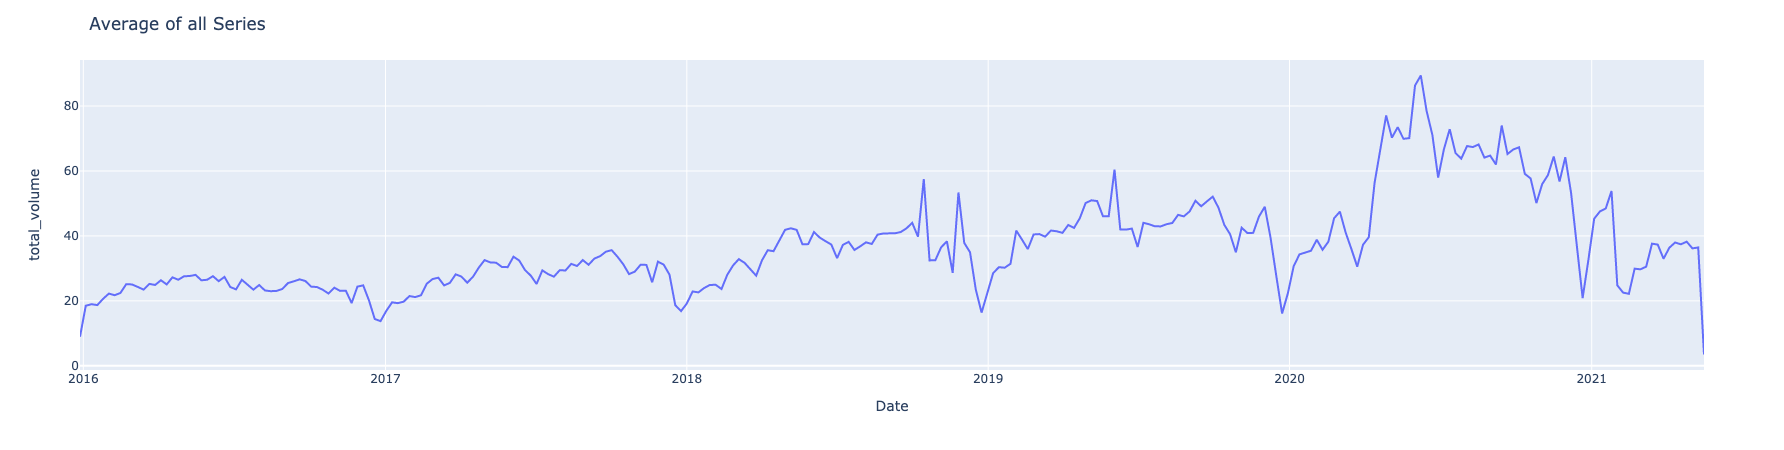

In [153]:
ts.plot_series_average(df= df_weekly, ts_settings= weekly_settings)

------
# Create TS lags

In [31]:
def create_lags(df: pd.core.frame.DataFrame, 
                ts_settings: dict,
                column: str, 
                lags: list
               ) -> pd.core.frame.DataFrame:
    '''
    Create lags of desired column. Will results in increased nan-values at head of dataframe.
    
    Inputs:
    -------
    df: DataFrame with date-ordered data
    ts_settings: Dictionary of modeling configuation
    column: Name of column for feature engineering
    lags: list of lags (int) to be created
    
    Output:
    ------
    df: DataFrame with additional columns
    '''
    for l in lags:
        df[f'{column}_lag_{l}'] = df[column].shift(l)
    return df[df[ts_settings['date_col']].notna()].copy()


def create_rolling(df: pd.core.frame.DataFrame, 
                   column: str, 
                   roll_lengths: list, 
                   method: list = ['mean']
                  ) -> pd.core.frame.DataFrame: 
    '''
    Create rolling statistics for desired column.
    
    Inputs:
    -------
    df: DataFrame with date-ordered data
    column: Name of column for feature engineering
    roll_lengths: list windows for rolling aggregation
    method: list of aggregation methods, valid entries include: 'mean', 'median', 'sum', 'std'
    
    Output:
    ------
    df: DataFrame with additional columns
    '''
    for roll in roll_lengths:
        for m in method:
            df[f'{column}_rolling_{roll}_{m}'] = df[column].rolling(roll).agg({column: m}).fillna(method='bfill').fillna(method='ffill')
    return df


def create_rolling_lags(df: pd.core.frame.DataFrame, 
                        column: str, 
                        lags: list, 
                        roll_length: list, 
                        method: list = ['mean']
                       ) -> pd.core.frame.DataFrame:
    '''
    Create rolling statistics at discrete times in the past.
    
    Inputs:
    -------
    df: DataFrame with date-ordered data
    column: Name of column for feature engineering
    lags: list of lags (int) to be created
    roll_lengths: list windows for rolling aggregation
    method: list of aggregation methods, valid entries include: 'mean', 'median', 'sum', 'std'
    
    Output:
    ------
    df: DataFrame with additional columns
    '''
    
    for l in lags:
        for roll in roll_length:
            for m in method:
                df[f'{column}_lag_{l}_rolling_{roll}_{m}'] = df[column].shift(l).rolling(roll).agg({column: m}).fillna(method='bfill').fillna(method='ffill')
    return df

# need to adjust this to work with all columns
def create_rolling_lags_many_columns(df: pd.core.frame.DataFrame,
                        columns: list,
                        lags: list, 
                        roll_length: list, 
                        method: list = ['mean']
                       ) -> pd.core.frame.DataFrame:
    '''
    Create rolling statistics at discrete times in the past.
    
    Inputs:
    -------
    df: DataFrame with date-ordered data
    column: Name of column for feature engineering
    lags: list of lags (int) to be created
    roll_lengths: list windows for rolling aggregation
    method: list of aggregation methods, valid entries include: 'mean', 'median', 'sum', 'std'
    
    Output:
    ------
    df: DataFrame with additional columns
    '''
    
    for col in columns:
        df = create_rolling_lags(df=df, column= col, lags= lags, roll_length= roll_length, method= method)
    return df

def create_differences(df: pd.core.frame.DataFrame, 
                       column: str, 
                       differences: list
                      ) -> pd.core.frame.DataFrame:
    '''
    Create differenced calculations.
    
    Inputs:
    -------
    df: DataFrame with date-ordered data
    column: Name of column for feature engineering
    differences: list of lags (int) to be used for differencing
    
    Output:
    -------
    df: DataFrame with additional columns
    '''
    for d in differences:
        df[f'{column}_{d}_difference'] = df[column] - df[column].shift(d)
    return df

In [32]:
%%time
base_df = df.copy()

test = create_lags(df= base_df, 
                   ts_settings= CST_settings,
                   column= 'CST Tickets', 
                   lags= [1, 7, 14])
test.tail(14)

CPU times: user 5.47 ms, sys: 2.92 ms, total: 8.38 ms
Wall time: 7.54 ms


,Date,Day,Orders,CST Tickets,All Tickets,Unique Requesters,Average Time/CST Ticket,Revenue,Tax,Shipping,Net,Week,Orders/Week,CST Tickets/Week,All Tickets/Week,Unique Requesters/Week,Avg Time/Ticket/Week,Net/Week,CST Tickets_lag_1,CST Tickets_lag_7,CST Tickets_lag_14
1938,2021-04-22,109.0,8826,2004.0,5095,3024,249.300102,746820.96,42941.10,34210.85,669669.01,16,NaN,NaN,NaN,NaN,NaN,NaN,2201.0,2030.0,1983.0
1939,2021-04-23,110.0,7737,1793.0,4414,2678,179.525656,658637.27,37314.96,29552.84,591769.47,16,NaN,NaN,NaN,NaN,NaN,NaN,2004.0,2001.0,1738.0
1940,2021-04-24,111.0,5392,878.0,1856,983,222.997696,432055.94,25563.39,21934.05,384558.50,16,NaN,NaN,NaN,NaN,NaN,NaN,1793.0,934.0,880.0
1941,2021-04-25,112.0,6986,930.0,1377,486,211.455738,551042.14,31595.90,27666.48,491779.76,16,NaN,NaN,NaN,NaN,NaN,NaN,878.0,840.0,902.0
1942,2021-04-26,113.0,11138,2049.0,3481,1669,188.937811,970102.56,53737.75,41009.37,875355.44,17,61337.0,11777.0,26463.0,15146.0,199.144738,4628780.47,930.0,1961.0,1913.0
1943,2021-04-27,114.0,10339,2179.0,4776,2808,228.795583,880682.36,49727.16,40772.44,790182.76,17,NaN,NaN,NaN,NaN,NaN,NaN,2049.0,2289.0,1996.0
1944,2021-04-28,115.0,10001,1974.0,4832,2978,205.920684,847212.68,48766.63,39625.43,758820.62,17,NaN,NaN,NaN,NaN,NaN,NaN,2179.0,2201.0,2114.0
1945,2021-04-29,116.0,9113,1947.0,5239,3250,201.512888,774064.94,44057.19,35713.28,694294.47,17,NaN,NaN,NaN,NaN,NaN,NaN,1974.0,2004.0,2030.0
1946,2021-04-30,117.0,8272,1737.0,4689,2882,178.906745,709374.03,40566.99,32145.17,636661.87,17,NaN,NaN,NaN,NaN,NaN,NaN,1947.0,1793.0,2001.0
1947,2021-05-01,118.0,5298,858.0,1906,1099,197.477163,411960.79,23602.90,22557.46,365800.43,17,NaN,NaN,NaN,NaN,NaN,NaN,1737.0,878.0,934.0


In [33]:
test = create_rolling(df= test,
                     column= 'CST Tickets', 
                     roll_lengths= [1,7,14],
                     method= ['sum'])
test

,Date,Day,Orders,CST Tickets,All Tickets,Unique Requesters,Average Time/CST Ticket,Revenue,Tax,Shipping,Net,Week,Orders/Week,CST Tickets/Week,All Tickets/Week,Unique Requesters/Week,Avg Time/Ticket/Week,Net/Week,CST Tickets_lag_1,CST Tickets_lag_7,CST Tickets_lag_14,CST Tickets_rolling_1_sum,CST Tickets_rolling_7_sum,CST Tickets_rolling_14_sum
0,2016-01-01,NaN,251,12.0,42,8,2398.333333,23400.05,0.00,734.60,22665.45,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,570.0,1412.0
1,2016-01-02,NaN,288,15.0,52,12,508.733333,23513.11,0.00,1092.10,22421.01,53,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,15.0,570.0,1412.0
2,2016-01-03,NaN,327,35.0,62,18,241.485714,16849.05,0.00,905.65,15943.40,53,NaN,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN,35.0,570.0,1412.0
3,2016-01-04,1.0,845,47.0,299,96,435.659574,59523.53,0.00,2210.35,57313.18,1,4215.0,564.0,1683.0,535.0,274.882979,384785.07,35.0,NaN,NaN,47.0,570.0,1412.0
4,2016-01-05,2.0,707,150.0,260,78,288.700000,78214.64,0.00,2053.60,76161.04,1,NaN,NaN,NaN,NaN,NaN,NaN,47.0,NaN,NaN,150.0,570.0,1412.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1947,2021-05-01,118.0,5298,858.0,1906,1099,197.477163,411960.79,23602.90,22557.46,365800.43,17,NaN,NaN,NaN,NaN,NaN,NaN,1737.0,878.0,934.0,858.0,11674.0,23640.0
1948,2021-05-02,119.0,7176,1033.0,1540,460,174.848963,572750.96,35055.93,30030.15,507664.88,17,NaN,NaN,NaN,NaN,NaN,NaN,858.0,930.0,840.0,1033.0,11777.0,23833.0
1949,2021-05-03,120.0,11772,2003.0,3570,1537,175.632172,1085991.56,65057.40,45241.62,975692.54,18,NaN,NaN,NaN,NaN,NaN,NaN,1033.0,2049.0,1961.0,2003.0,11731.0,23875.0
1950,2021-05-04,121.0,10368,2126.0,5368,3343,169.814976,903964.60,50755.68,41013.59,812195.33,18,NaN,NaN,NaN,NaN,NaN,NaN,2003.0,2179.0,2289.0,2126.0,11678.0,23712.0


In [34]:
test = create_rolling_lags(df= test,
                           column= 'CST Tickets',
                           lags= [7, 14, 28, 56],
                           roll_length= [3, 7],
                           method= ['mean'])
test

,Date,Day,Orders,CST Tickets,All Tickets,Unique Requesters,Average Time/CST Ticket,Revenue,Tax,Shipping,Net,Week,Orders/Week,CST Tickets/Week,All Tickets/Week,Unique Requesters/Week,Avg Time/Ticket/Week,Net/Week,CST Tickets_lag_1,CST Tickets_lag_7,CST Tickets_lag_14,CST Tickets_rolling_1_sum,CST Tickets_rolling_7_sum,CST Tickets_rolling_14_sum,CST Tickets_lag_7_rolling_3_mean,CST Tickets_lag_7_rolling_7_mean,CST Tickets_lag_14_rolling_3_mean,CST Tickets_lag_14_rolling_7_mean,CST Tickets_lag_28_rolling_3_mean,CST Tickets_lag_28_rolling_7_mean,CST Tickets_lag_56_rolling_3_mean,CST Tickets_lag_56_rolling_7_mean
0,2016-01-01,NaN,251,12.0,42,8,2398.333333,23400.05,0.00,734.60,22665.45,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,570.0,1412.0,20.666667,81.428571,20.666667,81.428571,20.666667,81.428571,20.666667,81.428571
1,2016-01-02,NaN,288,15.0,52,12,508.733333,23513.11,0.00,1092.10,22421.01,53,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,15.0,570.0,1412.0,20.666667,81.428571,20.666667,81.428571,20.666667,81.428571,20.666667,81.428571
2,2016-01-03,NaN,327,35.0,62,18,241.485714,16849.05,0.00,905.65,15943.40,53,NaN,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN,35.0,570.0,1412.0,20.666667,81.428571,20.666667,81.428571,20.666667,81.428571,20.666667,81.428571
3,2016-01-04,1.0,845,47.0,299,96,435.659574,59523.53,0.00,2210.35,57313.18,1,4215.0,564.0,1683.0,535.0,274.882979,384785.07,35.0,NaN,NaN,47.0,570.0,1412.0,20.666667,81.428571,20.666667,81.428571,20.666667,81.428571,20.666667,81.428571
4,2016-01-05,2.0,707,150.0,260,78,288.700000,78214.64,0.00,2053.60,76161.04,1,NaN,NaN,NaN,NaN,NaN,NaN,47.0,NaN,NaN,150.0,570.0,1412.0,20.666667,81.428571,20.666667,81.428571,20.666667,81.428571,20.666667,81.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1947,2021-05-01,118.0,5298,858.0,1906,1099,197.477163,411960.79,23602.90,22557.46,365800.43,17,NaN,NaN,NaN,NaN,NaN,NaN,1737.0,878.0,934.0,858.0,11674.0,23640.0,1558.333333,1709.428571,1655.000000,1698.571429,1411.333333,1641.285714,1264.666667,1428.571429
1948,2021-05-02,119.0,7176,1033.0,1540,460,174.848963,572750.96,35055.93,30030.15,507664.88,17,NaN,NaN,NaN,NaN,NaN,NaN,858.0,930.0,840.0,1033.0,11777.0,23833.0,1200.333333,1722.285714,1258.333333,1689.714286,979.333333,1603.428571,954.000000,1424.857143
1949,2021-05-03,120.0,11772,2003.0,3570,1537,175.632172,1085991.56,65057.40,45241.62,975692.54,18,NaN,NaN,NaN,NaN,NaN,NaN,1033.0,2049.0,1961.0,2003.0,11731.0,23875.0,1285.666667,1734.857143,1245.000000,1696.571429,1015.000000,1551.285714,1017.000000,1414.571429
1950,2021-05-04,121.0,10368,2126.0,5368,3343,169.814976,903964.60,50755.68,41013.59,812195.33,18,NaN,NaN,NaN,NaN,NaN,NaN,2003.0,2179.0,2289.0,2126.0,11678.0,23712.0,1719.333333,1719.142857,1696.666667,1738.428571,1368.666667,1474.714286,1380.000000,1403.285714


In [35]:
test = create_rolling_lags_many_columns(df= test,
                           columns= ['Average Time/CST Ticket'],
                           lags= [7],
                           roll_length= [7],
                           method= ['median'])
test

,Date,Day,Orders,CST Tickets,All Tickets,Unique Requesters,Average Time/CST Ticket,Revenue,Tax,Shipping,Net,Week,Orders/Week,CST Tickets/Week,All Tickets/Week,Unique Requesters/Week,Avg Time/Ticket/Week,Net/Week,CST Tickets_lag_1,CST Tickets_lag_7,CST Tickets_lag_14,CST Tickets_rolling_1_sum,CST Tickets_rolling_7_sum,CST Tickets_rolling_14_sum,CST Tickets_lag_7_rolling_3_mean,CST Tickets_lag_7_rolling_7_mean,CST Tickets_lag_14_rolling_3_mean,CST Tickets_lag_14_rolling_7_mean,CST Tickets_lag_28_rolling_3_mean,CST Tickets_lag_28_rolling_7_mean,CST Tickets_lag_56_rolling_3_mean,CST Tickets_lag_56_rolling_7_mean,Average Time/CST Ticket_lag_7_rolling_7_median
0,2016-01-01,NaN,251,12.0,42,8,2398.333333,23400.05,0.00,734.60,22665.45,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,570.0,1412.0,20.666667,81.428571,20.666667,81.428571,20.666667,81.428571,20.666667,81.428571,351.217949
1,2016-01-02,NaN,288,15.0,52,12,508.733333,23513.11,0.00,1092.10,22421.01,53,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,15.0,570.0,1412.0,20.666667,81.428571,20.666667,81.428571,20.666667,81.428571,20.666667,81.428571,351.217949
2,2016-01-03,NaN,327,35.0,62,18,241.485714,16849.05,0.00,905.65,15943.40,53,NaN,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN,35.0,570.0,1412.0,20.666667,81.428571,20.666667,81.428571,20.666667,81.428571,20.666667,81.428571,351.217949
3,2016-01-04,1.0,845,47.0,299,96,435.659574,59523.53,0.00,2210.35,57313.18,1,4215.0,564.0,1683.0,535.0,274.882979,384785.07,35.0,NaN,NaN,47.0,570.0,1412.0,20.666667,81.428571,20.666667,81.428571,20.666667,81.428571,20.666667,81.428571,351.217949
4,2016-01-05,2.0,707,150.0,260,78,288.700000,78214.64,0.00,2053.60,76161.04,1,NaN,NaN,NaN,NaN,NaN,NaN,47.0,NaN,NaN,150.0,570.0,1412.0,20.666667,81.428571,20.666667,81.428571,20.666667,81.428571,20.666667,81.428571,351.217949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1947,2021-05-01,118.0,5298,858.0,1906,1099,197.477163,411960.79,23602.90,22557.46,365800.43,17,NaN,NaN,NaN,NaN,NaN,NaN,1737.0,878.0,934.0,858.0,11674.0,23640.0,1558.333333,1709.428571,1655.000000,1698.571429,1411.333333,1641.285714,1264.666667,1428.571429,220.265287
1948,2021-05-02,119.0,7176,1033.0,1540,460,174.848963,572750.96,35055.93,30030.15,507664.88,17,NaN,NaN,NaN,NaN,NaN,NaN,858.0,930.0,840.0,1033.0,11777.0,23833.0,1200.333333,1722.285714,1258.333333,1689.714286,979.333333,1603.428571,954.000000,1424.857143,220.265287
1949,2021-05-03,120.0,11772,2003.0,3570,1537,175.632172,1085991.56,65057.40,45241.62,975692.54,18,NaN,NaN,NaN,NaN,NaN,NaN,1033.0,2049.0,1961.0,2003.0,11731.0,23875.0,1285.666667,1734.857143,1245.000000,1696.571429,1015.000000,1551.285714,1017.000000,1414.571429,220.265287
1950,2021-05-04,121.0,10368,2126.0,5368,3343,169.814976,903964.60,50755.68,41013.59,812195.33,18,NaN,NaN,NaN,NaN,NaN,NaN,2003.0,2179.0,2289.0,2126.0,11678.0,23712.0,1719.333333,1719.142857,1696.666667,1738.428571,1368.666667,1474.714286,1380.000000,1403.285714,220.265287


In [36]:
test = create_differences(df= test,
                         column = 'CST Tickets',
                         differences= [7, 35, 365])
test
# if we look at the df.head() we'll see lots of nans because of how these features are generated
# in practice, we'd drop the firts chunk of those rows with lots of nans in engineered features
# the df.tail() shows what these look like when filled in properly
test[['Date'] + [x for x in test.columns if 'CST' in x]].head(5)

,Date,CST Tickets,Average Time/CST Ticket,CST Tickets/Week,CST Tickets_lag_1,CST Tickets_lag_7,CST Tickets_lag_14,CST Tickets_rolling_1_sum,CST Tickets_rolling_7_sum,CST Tickets_rolling_14_sum,CST Tickets_lag_7_rolling_3_mean,CST Tickets_lag_7_rolling_7_mean,CST Tickets_lag_14_rolling_3_mean,CST Tickets_lag_14_rolling_7_mean,CST Tickets_lag_28_rolling_3_mean,CST Tickets_lag_28_rolling_7_mean,CST Tickets_lag_56_rolling_3_mean,CST Tickets_lag_56_rolling_7_mean,Average Time/CST Ticket_lag_7_rolling_7_median,CST Tickets_7_difference,CST Tickets_35_difference,CST Tickets_365_difference
0,2016-01-01,12.0,2398.333333,NaN,NaN,NaN,NaN,12.0,570.0,1412.0,20.666667,81.428571,20.666667,81.428571,20.666667,81.428571,20.666667,81.428571,351.217949,NaN,NaN,NaN
1,2016-01-02,15.0,508.733333,NaN,12.0,NaN,NaN,15.0,570.0,1412.0,20.666667,81.428571,20.666667,81.428571,20.666667,81.428571,20.666667,81.428571,351.217949,NaN,NaN,NaN
2,2016-01-03,35.0,241.485714,NaN,15.0,NaN,NaN,35.0,570.0,1412.0,20.666667,81.428571,20.666667,81.428571,20.666667,81.428571,20.666667,81.428571,351.217949,NaN,NaN,NaN
3,2016-01-04,47.0,435.659574,564.0,35.0,NaN,NaN,47.0,570.0,1412.0,20.666667,81.428571,20.666667,81.428571,20.666667,81.428571,20.666667,81.428571,351.217949,NaN,NaN,NaN
4,2016-01-05,150.0,288.700000,NaN,47.0,NaN,NaN,150.0,570.0,1412.0,20.666667,81.428571,20.666667,81.428571,20.666667,81.428571,20.666667,81.428571,351.217949,NaN,NaN,NaN


In [37]:
test[['Date'] + [x for x in test.columns if 'CST' in x]].tail(5)

,Date,CST Tickets,Average Time/CST Ticket,CST Tickets/Week,CST Tickets_lag_1,CST Tickets_lag_7,CST Tickets_lag_14,CST Tickets_rolling_1_sum,CST Tickets_rolling_7_sum,CST Tickets_rolling_14_sum,CST Tickets_lag_7_rolling_3_mean,CST Tickets_lag_7_rolling_7_mean,CST Tickets_lag_14_rolling_3_mean,CST Tickets_lag_14_rolling_7_mean,CST Tickets_lag_28_rolling_3_mean,CST Tickets_lag_28_rolling_7_mean,CST Tickets_lag_56_rolling_3_mean,CST Tickets_lag_56_rolling_7_mean,Average Time/CST Ticket_lag_7_rolling_7_median,CST Tickets_7_difference,CST Tickets_35_difference,CST Tickets_365_difference
1947,2021-05-01,858.0,197.477163,NaN,1737.0,878.0,934.0,858.0,11674.0,23640.0,1558.333333,1709.428571,1655.000000,1698.571429,1411.333333,1641.285714,1264.666667,1428.571429,220.265287,-20.0,-34.0,-599.0
1948,2021-05-02,1033.0,174.848963,NaN,858.0,930.0,840.0,1033.0,11777.0,23833.0,1200.333333,1722.285714,1258.333333,1689.714286,979.333333,1603.428571,954.000000,1424.857143,220.265287,103.0,155.0,354.0
1949,2021-05-03,2003.0,175.632172,NaN,1033.0,2049.0,1961.0,2003.0,11731.0,23875.0,1285.666667,1734.857143,1245.000000,1696.571429,1015.000000,1551.285714,1017.000000,1414.571429,220.265287,-46.0,-42.0,1469.0
1950,2021-05-04,2126.0,169.814976,NaN,2003.0,2179.0,2289.0,2126.0,11678.0,23712.0,1719.333333,1719.142857,1696.666667,1738.428571,1368.666667,1474.714286,1380.000000,1403.285714,220.265287,-53.0,-223.0,421.0
1951,2021-05-05,1748.0,170.806798,NaN,2126.0,1974.0,2201.0,1748.0,11452.0,23259.0,2067.333333,1686.714286,2150.333333,1750.857143,1870.000000,1493.857143,1717.333333,1376.428571,211.455738,-226.0,-235.0,-1098.0


-----
# Create a Forecast distance dataset

In [38]:
def create_fd(df: pd.core.frame.DataFrame, 
              ts_settings: dict,
              excluded: typing.Optional[list] = None
             ) -> pd.core.frame.DataFrame:
    '''
    Duplicates and shifts dataset by forecast distance. Required for forecast distance modeling.
    Be careful with size expansion of datasets, especially with long forecast horizon.
    
    Inputs:
    -------
    df: DataFrame with date-ordered data
    ts_settings: dictionary of project settings
    excluded: (Optional) list of columns to not shift   
    
    Output:
    -------
    output_df: DataFrame, linear increase in size by forecast horizon
    '''
    output_df = pd.DataFrame()
    date_col = ts_settings['date_col']
    series_id = ts_settings['series_id']
    
    # loop through each forecast distance, shift all columns except date_col and series_id
    for fd in range(ts_settings['fd_start'], ts_settings['fd_end']+1):
        
        # determine which columns will shift and which won't
        if series_id is not None:
            shift_cols = list(set(df.columns).difference(set([date_col, series_id])))
            omit_cols = [date_col, series_id]
            
            if excluded is not None:
                shift_cols = list(set(shift_cols).difference(set(excluded)))
                omit_cols += excluded
            
            # shift the future values back for each series
            tmp_df = pd.DataFrame()
            for series in df[series_id].unique():
                series_df = df[df[series_id]==series].copy()
                series_df = series_df[shift_cols].shift(-(fd-1))
                series_df['FD'] = fd
                
                # add the non-shifted columns back in
                for col in omit_cols:
                    series_df[col] = df[df[series_id]==series][col]
                    
                # fix column order
                series_df = series_df[['FD'] + omit_cols + shift_cols]

                # add the series-iteration data for each FD-iteration
                tmp_df = tmp_df.append(series_df)

        else:
            shift_cols = list(set(df.columns).difference(set([date_col]))) 
            omit_cols = [date_col]
            
            if excluded is not None:
                shift_cols = list(set(shift_cols).difference(set(excluded)))
                omit_cols += excluded
                
            # shift the future values back
            tmp_df = df.copy()
            tmp_df = tmp_df[shift_cols].shift(-(fd-1))
            tmp_df['FD'] = fd
        
            # add the non-shifted columns back in
            for col in omit_cols:
                tmp_df[col] = df[col]
                
        # add the FD-iteration data to output
        output_df = output_df.append(tmp_df)
        
    # adding new things to fill gaps created by FD
    # sort the dataset, trying to use series_id
    try:
        output_df = output_df[['FD'] + df.columns.tolist()].sort_values([date_col, series_id, 'FD'])
        output_df.groupby([date_col, series_id]).fillna(method= 'ffill').fillna(method= 'bfill', inplace= True)
        output_df.reset_index(drop= True, inplace= True)
    except: 
        output_df = output_df[['FD'] + df.columns.tolist()].sort_values([date_col, 'FD'])
        output_df.groupby([date_col]).fillna(method= 'ffill').fillna(method= 'bfill', inplace= True)
        output_df.reset_index(drop= True, inplace= True)

    return output_df

In [39]:
# drop the first row of the test_df with nans
test_dropped = test[test['Date'] > (test['Date'].min() + pd.DateOffset(56))]

In [40]:
%%time
test2 = create_fd(df= test_dropped,
                 ts_settings= CST_settings,
                 excluded= None)

test2.head(20)

CPU times: user 800 ms, sys: 50.6 ms, total: 850 ms
Wall time: 856 ms


,FD,Date,Day,Orders,CST Tickets,All Tickets,Unique Requesters,Average Time/CST Ticket,Revenue,Tax,Shipping,Net,Week,Orders/Week,CST Tickets/Week,All Tickets/Week,Unique Requesters/Week,Avg Time/Ticket/Week,Net/Week,CST Tickets_lag_1,CST Tickets_lag_7,CST Tickets_lag_14,CST Tickets_rolling_1_sum,CST Tickets_rolling_7_sum,CST Tickets_rolling_14_sum,CST Tickets_lag_7_rolling_3_mean,CST Tickets_lag_7_rolling_7_mean,CST Tickets_lag_14_rolling_3_mean,CST Tickets_lag_14_rolling_7_mean,CST Tickets_lag_28_rolling_3_mean,CST Tickets_lag_28_rolling_7_mean,CST Tickets_lag_56_rolling_3_mean,CST Tickets_lag_56_rolling_7_mean,Average Time/CST Ticket_lag_7_rolling_7_median,CST Tickets_7_difference,CST Tickets_35_difference,CST Tickets_365_difference
0,1,2016-02-27,55.0,491.0,46.0,61.0,41.0,425.695652,48800.37,0.0,1876.55,46923.82,8.0,NaN,NaN,NaN,NaN,NaN,NaN,215.0,17.0,36.0,46.0,921.0,1372.0,81.666667,64.428571,65.000000,83.857143,62.000000,86.142857,20.666667,81.428571,356.000000,29.0,22.0,NaN
1,2,2016-02-27,56.0,637.0,31.0,53.0,30.0,216.806452,31651.60,0.0,1832.90,29818.70,8.0,NaN,NaN,NaN,NaN,NaN,NaN,46.0,45.0,24.0,31.0,907.0,1379.0,25.333333,67.428571,63.333333,82.714286,66.666667,88.428571,20.666667,81.428571,356.000000,-14.0,8.0,NaN
2,3,2016-02-27,57.0,1283.0,23.0,287.0,129.0,611.391304,89367.22,0.0,3579.00,85788.22,9.0,6844.0,559.0,1505.0,707.0,239.298748,560193.3,31.0,316.0,19.0,23.0,614.0,1383.0,126.000000,109.857143,26.333333,58.714286,33.333333,67.714286,32.333333,81.428571,296.438462,-293.0,-147.0,NaN
3,4,2016-02-27,58.0,1193.0,244.0,275.0,131.0,215.811475,99219.80,0.0,3871.20,95348.60,9.0,NaN,NaN,NaN,NaN,NaN,NaN,23.0,38.0,130.0,244.0,820.0,1497.0,133.000000,96.714286,57.666667,73.857143,75.666667,85.571429,77.333333,81.428571,356.000000,206.0,206.0,NaN
4,5,2016-02-27,59.0,1181.0,31.0,272.0,131.0,372.290323,109812.17,0.0,3698.60,106113.57,9.0,NaN,NaN,NaN,NaN,NaN,NaN,244.0,231.0,33.0,31.0,620.0,1495.0,195.000000,125.000000,60.666667,57.285714,76.000000,64.714286,91.666667,81.428571,295.377778,-200.0,-155.0,NaN
5,6,2016-02-27,60.0,1118.0,217.0,245.0,114.0,182.552995,97181.70,0.0,3759.65,93422.05,9.0,NaN,NaN,NaN,NaN,NaN,NaN,31.0,30.0,214.0,217.0,807.0,1498.0,99.666667,98.714286,125.666667,83.714286,121.666667,84.285714,153.666667,81.428571,356.000000,187.0,192.0,NaN
6,7,2016-02-27,61.0,862.0,8.0,246.0,118.0,340.875000,98730.32,0.0,3326.65,95403.67,9.0,NaN,NaN,NaN,NaN,NaN,NaN,217.0,215.0,14.0,8.0,600.0,1492.0,158.666667,127.428571,87.000000,67.142857,73.000000,68.857143,106.666667,81.000000,295.377778,-207.0,-117.0,NaN
7,1,2016-02-28,56.0,637.0,31.0,53.0,30.0,216.806452,31651.60,0.0,1832.90,29818.70,8.0,NaN,NaN,NaN,NaN,NaN,NaN,46.0,45.0,24.0,31.0,907.0,1379.0,25.333333,67.428571,63.333333,82.714286,66.666667,88.428571,20.666667,81.428571,356.000000,-14.0,8.0,NaN
8,2,2016-02-28,57.0,1283.0,23.0,287.0,129.0,611.391304,89367.22,0.0,3579.00,85788.22,9.0,6844.0,559.0,1505.0,707.0,239.298748,560193.3,31.0,316.0,19.0,23.0,614.0,1383.0,126.000000,109.857143,26.333333,58.714286,33.333333,67.714286,32.333333,81.428571,296.438462,-293.0,-147.0,NaN
9,3,2016-02-28,58.0,1193.0,244.0,275.0,131.0,215.811475,99219.80,0.0,3871.20,95348.60,9.0,NaN,NaN,NaN,NaN,NaN,NaN,23.0,38.0,130.0,244.0,820.0,1497.0,133.000000,96.714286,57.666667,73.857143,75.666667,85.571429,77.333333,81.428571,356.000000,206.0,206.0,NaN


In [41]:
%%time
# test with multiseries data
daily_sample = df_daily[df_daily['variant_group_id_region'].isin(df_daily['variant_group_id_region'].unique()[:50])].copy()
# daily_sample.shape[0]

test3 = create_fd(df= daily_sample,
                ts_settings= daily_settings,
                 excluded= ['region', 'variant_group_id', 'product_id', 'brand_family', 'brand_name', 'catalog_number'])

test3.head(20)

CPU times: user 2min 18s, sys: 4.03 s, total: 2min 22s
Wall time: 2min 23s


,FD,date,region,variant_group_id,avg_list_price,avg_sold_price,num_orders,avg_volume,min_volume,max_volume,total_volume,total_revenue,variant_group_id_region,product_id,brand_family,brand_name,catalog_number
0,1,2016-01-01,west,101000202,10.090,10.090000,4.0,1.0,1.0,2.0,6.0,64.14,101000202_west,202,Bella+Canvas,Bella + Canvas,3005
1,2,2016-01-01,west,101000202,5.650,5.650000,2.0,1.0,1.0,1.0,2.0,11.30,101000202_west,202,Bella+Canvas,Bella + Canvas,3005
2,3,2016-01-01,west,101000202,8.970,8.970000,4.0,1.0,1.0,1.0,4.0,35.88,101000202_west,202,Bella+Canvas,Bella + Canvas,3005
3,4,2016-01-01,west,101000202,5.650,5.420000,4.0,1.0,1.0,1.0,4.0,21.68,101000202_west,202,Bella+Canvas,Bella + Canvas,3005
4,5,2016-01-01,west,101000202,5.650,5.650000,4.0,1.0,1.0,2.0,6.0,33.90,101000202_west,202,Bella+Canvas,Bella + Canvas,3005
5,6,2016-01-01,west,101000202,5.650,5.314000,10.0,1.0,1.0,1.0,10.0,53.14,101000202_west,202,Bella+Canvas,Bella + Canvas,3005
6,7,2016-01-01,west,101000202,5.650,5.090000,4.0,1.0,1.0,1.0,4.0,20.36,101000202_west,202,Bella+Canvas,Bella + Canvas,3005
7,1,2016-01-01,texas,101000716,3.070,3.070000,10.0,3.0,1.0,6.0,30.0,79.50,101000716_texas,716,Gildan,Anvil,980
8,2,2016-01-01,texas,101000716,2.440,2.440000,2.0,1.0,1.0,1.0,2.0,4.88,101000716_texas,716,Gildan,Anvil,980
9,3,2016-01-01,texas,101000716,2.440,2.340000,2.0,2.0,2.0,2.0,4.0,9.36,101000716_texas,716,Gildan,Anvil,980


In [42]:
%%time
# test with multiseries data
weekly_sample = df_weekly[df_weekly['variant_id_region'].isin(df_weekly['variant_id_region'].unique()[:50])].copy()
weekly_sample.shape[0]

test4 = create_fd(df= weekly_sample,
                ts_settings= weekly_settings,
                excluded= None)

test4.head(20)

CPU times: user 6.9 s, sys: 396 ms, total: 7.3 s
Wall time: 7.53 s


,FD,date,variant_id_region,avg_list_price,avg_sold_price,num_orders,avg_volume,min_volume,max_volume,total_volume,total_revenue
0,1,2015-12-28,18039-midwest,8.29,8.290,2.0,1.0,1.0,1.0,2.0,16.58
1,2,2015-12-28,18039-midwest,8.57,7.200,2.0,35.0,35.0,35.0,70.0,504.00
2,3,2015-12-28,18039-midwest,8.57,7.710,2.0,1.0,1.0,1.0,2.0,15.42
3,4,2015-12-28,18039-midwest,8.32,8.320,2.0,1.0,1.0,1.0,2.0,16.64
4,5,2015-12-28,18039-midwest,8.32,7.490,2.0,1.0,1.0,1.0,2.0,14.98
5,6,2015-12-28,18039-midwest,8.63,8.630,2.0,1.0,1.0,1.0,2.0,17.26
6,7,2015-12-28,18039-midwest,8.63,8.280,2.0,1.0,1.0,1.0,2.0,16.56
7,1,2015-12-28,18058-texas,9.93,9.930,2.0,1.0,1.0,1.0,2.0,19.86
8,2,2015-12-28,18058-texas,9.93,9.930,2.0,1.0,1.0,1.0,2.0,19.86
9,3,2015-12-28,18058-texas,9.93,9.930,4.0,1.0,1.0,1.0,4.0,39.72


---
# Gap filling with pivot_table approach

### Need to add options to drop leading and lagging zeros
### I'll accomplish this by getting a first/last occurence, and using index values

### This is important to help control dataset sizes

In [43]:
def fill_row_gaps_old(df: pd.core.frame.DataFrame,
                  ts_settings: dict,
                  agg_method: typing.Optional[typing.Union[str,dict]] = 'sum',
                  fill_method: typing.Optional[str] = 'ffill',
                  static_columns: typing.Optional[list]= None,
                  freq: typing.Optional[str] = None
                 ) -> pd.core.frame.DataFrame:
    '''
    Function to fill date-gaps between records. Uses the pivot_table, reindex, and melt approach.
    
    Inputs:
    -------
    df: Pandas dataframe with training data
    ts_settings: Dictionary of settings
    agg_method: (Optional) method to use to aggregate into desired frequency. Can use a dict with method for each column.
    fill_method: (Optional) method to use to fill missing values covariates columns after reindexing
    static_columns: (Optional) list of columns that are constant for all dates
    freq: (Optional) spacing between rows. Can be determined automatically
    
    Output:
    -------
    df: Pandas dataframe with gaps filled in training data
    '''
    assert(agg_method in ['sum', 'mean']), "agg_method parameter allowed values are 'sum' or 'mean'"
    
    # define some convenience variables
    date_col = ts_settings['date_col']
    series_id = ts_settings['series_id']
    target = ts_settings['target']
    
    # fix date-typing
    df[date_col] = pd.to_datetime(df[date_col])
    
    # get all available dates
    if freq == None:
        freq = check_gap(df, ts_settings)[0].upper()
        assert(freq != 'C'), 'Date frequency cannot be automatically detected, please provide it explicity'
    dates = pd.date_range(start= df[date_col].min(), end= df[date_col].max(), freq= freq)
#     old_dates = [pd.to_datetime(x) for x in df[date_col].unique()]
#     new_dates = [pd.to_datetime(x) for x in dates]
#     print(f'Filling from {df[date_col].min().date()} to {df[date_col].max().date()}, which will add {len(set(old_dates).difference(new_dates))} dates')
    
    # pivot dataset
    if series_id != None:
        df_wide = df.pivot_table(
            index= series_id,
            columns= date_col,
            values= target,
            aggfunc= agg_method,
            fill_value= 0
            ).reindex(dates, axis=1, fill_value= 0).reset_index()
        
        # change back to long-format,
        df_long = pd.melt(df_wide, id_vars=[series_id], var_name= date_col, value_name= target)#.rename(columns= {''#.drop('value', axis=1)
        
    else:
        df_wide = df.pivot_table(
            index= None,
            columns= date_col,
            values= target,
            aggfunc= agg_method,
            fill_value= 0
            ).reindex(dates, axis=1, fill_value= 0).reset_index()
        
        # change back to long-format,
        df_long = pd.melt(df_wide, id_vars=None, var_name= date_col, value_name= target).iloc[1:,:]

    # join back any of the other column values
    df_long[date_col] = pd.to_datetime(df_long[date_col])

    if series_id != None:
        df_merge = df_long.merge(df[[x for x in df.columns if x != target]], on= [date_col, series_id], how= 'left').fillna(method= fill_method)
    else:
        df_merge = df_long.merge(df[[x for x in df.columns if x != target]], on= [date_col], how= 'left').fillna(method= fill_method)
    

    # fill static_column values
    if static_columns != None:
    
        if series_id != None:
            static_values = df.groupby(series_id)[static_columns].agg(lambda x: x.value_counts().index[0]).to_dict()
            for c in static_columns:
                df_merge[c] = df_merge[series_id].map(static_values[c])
        else:
            df_merge[static_columns] = df_merge[static_columns].fillna(method= 'bfill').fillna(method= 'ffill')
                    
    return df_merge

In [144]:
def fill_row_gaps(df: pd.core.frame.DataFrame,
                  ts_settings: dict,
                  agg_method: typing.Optional[typing.Union[str,dict]] = 'sum',
                  fill_method: typing.Optional[str] = 'ffill',
                  target_fill: typing.Optional[typing.Union[str,int]]= 0,
                   static_columns: typing.Optional[list]= None,
                  freq: typing.Optional[str] = None
                 ) -> pd.core.frame.DataFrame:
    '''
    Function to fill date-gaps between records. Uses the cross-join approach on series-specific start and end date ranges.
    
    Inputs:
    -------
    df: Pandas dataframe with training data
    ts_settings: Dictionary of settings
    agg_method: (Optional) method to use to aggregate into desired frequency. Can use a dict with method for each column.
    fill_method: (Optional) method to use to fill missing values covariates columns after reindexing
    target_fill: (Optional) method to use to fill missing target values
    static_columns: (Optional) list of columns that are constant for all dates
    freq: (Optional) spacing between rows. Can be determined automatically
    
    Output:
    -------
    df: Pandas dataframe with gaps filled in training data
    '''
    assert(agg_method in ['sum', 'mean']), "agg_method parameter allowed values are 'sum' or 'mean'"
    
    # define some convenience variables
    date_col = ts_settings['date_col']
    series_id = ts_settings['series_id']
    target = ts_settings['target']
    
    # fix date-typing
    df[date_col] = pd.to_datetime(df[date_col])
    
    # get all available dates
    if freq == None:
        freq = check_gap(df, ts_settings)[0].upper()
        assert(freq != 'C'), 'Date frequency cannot be automatically detected, please provide it explicity'
        
    # fill in missing date-steps
    if series_id != None:
        # build relevant date-steps with series-start and series-stop bounds
        first_obs = df[(df[target] != 0) & (df[target].notna())].groupby(series_id)[date_col].min().to_dict()
        last_obs = df[(df[target] != 0) & (df[target].notna())].groupby(series_id)[date_col].max().to_dict()
        series_dates = pd.DataFrame([first_obs, last_obs]).T.reset_index()
        series_dates.columns= [series_id, 'start_date', 'end_date']
        all_dates = pd.DataFrame(pd.date_range(start= df[date_col].min(), end= df[date_col].max(), freq= freq), columns = [date_col])

        # Cross join in pandas
        all_dates['key'] = 0
        series_dates['key'] = 0
        cross = all_dates.merge(series_dates, on='key', how='outer')
        cross =  cross[(cross[date_col] >= pd.to_datetime(cross['start_date'])) & (cross[date_col] <= pd.to_datetime(cross['end_date']))].copy().drop(['start_date', 'end_date', 'key'], axis=1)
        
        # add in known information
        output_df = cross.merge(df, on= [date_col, series_id], how= 'left')
    
    else:
        all_dates = pd.DataFrame(pd.date_range(start= df[date_col].min(), end= df[date_col].max(), freq= freq), columns = [date_col])
        # add in known information
        output_df = all_dates.merge(df, on= [date_col, series_id], how= 'left')
        
    # fill missing targets values
    if type(target_fill) == int:
        output_df[target].fillna(value= target_fill, inplace= True)
    else:
        output_df[target].fillna(method= target_fill, inplace= True)


    # fill static_column values
    if static_columns != None:
    
        if series_id != None:
            static_values = df.groupby(series_id)[static_columns].agg(lambda x: x.value_counts().index[0]).to_dict()
            for c in static_columns:
                output_df[c] = output_df[series_id].map(static_values[c])
        else:
            output_df[static_columns] = output_df[static_columns].fillna(method= 'bfill').fillna(method= 'ffill')

    return output_df

In [68]:
%%time
test5 = fill_row_gaps(df = df,
                  ts_settings= CST_settings,
                  agg_method = 'sum',
                  freq = None
                 )
test5.shape

CPU times: user 9.84 ms, sys: 3.9 ms, total: 13.7 ms
Wall time: 14.9 ms


(1952, 19)

In [71]:
%%time
test5 = fill_row_gaps_old(df = df,
                  ts_settings= CST_settings,
                  agg_method = 'sum',
                  freq = None
                 )

test5.shape

CPU times: user 31.7 ms, sys: 3.39 ms, total: 35.1 ms
Wall time: 35.2 ms


(1952, 18)

In [72]:
%%time
test6 = fill_row_gaps(df = daily_sample,
                  ts_settings= daily_settings,
                  agg_method = 'sum',
                  freq = 'D',
                static_columns= ['region', 'variant_group_id', 'product_id', 'brand_family', 'brand_name', 'catalog_number']
                 )

test6.shape

CPU times: user 330 ms, sys: 26.2 ms, total: 356 ms
Wall time: 357 ms


(98020, 16)

In [73]:
%%time
test6 = fill_row_gaps_old(df = daily_sample,
                  ts_settings= daily_settings,
                  agg_method = 'sum',
                  freq = 'D',
                static_columns= ['region', 'variant_group_id', 'product_id', 'brand_family', 'brand_name', 'catalog_number']
                 )

test6.shape

CPU times: user 699 ms, sys: 32.4 ms, total: 732 ms
Wall time: 734 ms


(98050, 16)

In [49]:
%%time
test7 = fill_row_gaps(df = df_daily,
                  ts_settings= daily_settings,
                  agg_method = 'sum',
                  freq = 'D'                 )

test7.shape

CPU times: user 3.06 s, sys: 985 ms, total: 4.04 s
Wall time: 4.08 s


(2672381, 16)

In [74]:
%%time
test7 = fill_row_gaps_old(df = df_daily,
                  ts_settings= daily_settings,
                  agg_method = 'sum',
                  freq = 'D'                 )

test7.shape

CPU times: user 5.55 s, sys: 1.48 s, total: 7.03 s
Wall time: 7.15 s


(3019940, 16)

In [75]:
%%time
test7 = fill_row_gaps(df = df_daily,
                  ts_settings= daily_settings,
                  agg_method = 'sum',
                  freq = 'D',
                  static_columns= ['region', 'variant_group_id', 'product_id', 'brand_family', 'brand_name', 'catalog_number']
                 )

test7.shape

CPU times: user 8.79 s, sys: 816 ms, total: 9.6 s
Wall time: 9.63 s


(2672381, 16)

In [76]:
%%time
test7 = fill_row_gaps_old(df = df_daily,
                  ts_settings= daily_settings,
                  agg_method = 'sum',
                  freq = 'D',
                  static_columns= ['region', 'variant_group_id', 'product_id', 'brand_family', 'brand_name', 'catalog_number']
                 )

test7.shape

CPU times: user 10.8 s, sys: 1.59 s, total: 12.4 s
Wall time: 12.4 s


(3019940, 16)

In [77]:
%%time
test7.groupby('variant_group_id_region').nunique()

CPU times: user 7.16 s, sys: 516 ms, total: 7.68 s
Wall time: 7.69 s


,date,total_volume,region,variant_group_id,avg_list_price,avg_sold_price,num_orders,avg_volume,min_volume,max_volume,total_revenue,product_id,brand_family,brand_name,catalog_number
variant_group_id_region,,,,,,,,,,,,,,,
101000173_midwest,1961,91,1,1,105,637,52,18,11,29,1092,1,1,1,1
101000173_northeast,1961,92,1,1,90,508,48,26,21,31,1014,1,1,1,1
101000173_south,1961,135,1,1,82,678,64,22,20,33,1142,1,1,1,1
101000173_texas,1961,136,1,1,75,646,66,24,18,37,1107,1,1,1,1
101000173_west,1961,52,1,1,71,454,43,23,19,33,940,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503014773_midwest,1961,36,1,1,105,516,43,15,12,20,822,1,1,1,1
503014773_northeast,1961,25,1,1,98,496,42,14,11,20,789,1,1,1,1
503014773_south,1961,24,1,1,102,500,44,13,11,20,780,1,1,1,1


-------
# Create ts dataset

In [54]:
# prepare ts-forecasting dataset (reverse lists of lagged and KIA columns for nowcasting)

# automatically lag all non KIA

In [78]:
def prepare_ts_dataset(df: pd.core.frame.DataFrame,
                       date_col: str, 
                       target: str,
                       bhg: typing.Optional[int]= -1,
                       series_id: typing.Optional[str]= None,
                       KIAs: typing.Optional[list]= None
                      ):
    
    '''
    Lags all non-KIA values to prevent ts-data-leakage.
    
    Inputs:
    -------
    df: Pandas dataframe training dataset,
    date_col: name of primary date-column,
    target: name of target-column,
    bhg: number of steps into the past to lag non-KIA features (blind history gap)
    series_id: name of primary series-id-column,
    KIA: list of feature names or variables for which values are known at prediction time or known in advance (KIA)
    
    Output:
    df: Pandas dataframe with lagged values
    '''
    assert(bhg <= 0), 'bhg must be zero or negative'
    
    # retain original order to ensure output matches input
    order = df.columns.tolist()
    
    # add target, date_col, and series_id to KIA list for shifting
    if series_id:
        KIAs += [target, date_col, series_id]
    else:
        KIAs += [target, date_col]
    non_KIAs = [x for x in df.columns if x not in KIAs]
    output_df = df.copy()
    
    # shift non-KIAs (easy way)
    df[non_KIAs] = df[non_KIAs].shift(bhg)

    return output_df[order]

In [79]:
%%time
df_KIAs = ['Day', 'Week']

df_dev = prepare_ts_dataset(df= df,
                  date_col= 'Date',
                  target= 'CST Tickets',
                  bhg= -1,
                  series_id= None,
                  KIAs= df_KIAs)

df_dev.head(5)

CPU times: user 4.74 ms, sys: 1.96 ms, total: 6.7 ms
Wall time: 5.3 ms


,Date,Day,Orders,CST Tickets,All Tickets,Unique Requesters,Average Time/CST Ticket,Revenue,Tax,Shipping,Net,Week,Orders/Week,CST Tickets/Week,All Tickets/Week,Unique Requesters/Week,Avg Time/Ticket/Week,Net/Week
0,2016-01-01,NaN,288.0,12.0,52.0,12.0,508.733333,23513.11,0.0,1092.10,22421.01,53,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-02,NaN,327.0,15.0,62.0,18.0,241.485714,16849.05,0.0,905.65,15943.40,53,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-03,NaN,845.0,35.0,299.0,96.0,435.659574,59523.53,0.0,2210.35,57313.18,53,4215.0,564.0,1683.0,535.0,274.882979,384785.07
3,2016-01-04,1.0,707.0,47.0,260.0,78.0,288.700000,78214.64,0.0,2053.60,76161.04,1,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-05,2.0,674.0,150.0,263.0,75.0,351.217949,76816.34,0.0,2097.40,74718.94,1,NaN,NaN,NaN,NaN,NaN,NaN


-----
# Fill NaNs in features values

In [80]:
# default, use the rolling_median approach with create_rolling(method= 'median')

def fill_nans(df: pd.core.frame.DataFrame,
             ts_settings: dict,
             numeric_columns: typing.Optional[list]= None,
             numeric_method: typing.Optional[dict]= 'rolling_median',
             roll_length: typing.Optional[int]= 7,
             cat_columns: typing.Optional[list]= None,
             cat_method: typing.Optional[dict]= 'most recent'
             ) -> pd.core.frame.DataFrame:
    '''
    Fill missing values in defined columns.
    
    Inputs:
    -------
    df: Pandas dataframe
    ts_settings: dictionary of settings
    numeric_columns: names of numeric-type columns to fill
    numeric_methods: method to be used to fill. Accepts any methods that can be used by 'create_rolling()' function (mean, median, sum) or dict with a method for each column
    roll_length: number of time-steps in past to use for rolling statistic
    cat_columns: names of categorical/text columns to fill
    cat_method: method to used to fill categorical. Accepts 'most recent' or 'most common' or dict with a method for each column
    
    Outputs:
    --------
    df: Pandas dataframe    
    '''
    
    assert(numeric_method in ['mean', 'median', 'max', 'rolling_mean', 'rolling_median', 'rolling_max']), "numeric_method parameter accepts 'mean', 'median', 'max', 'rolling_mean', 'rolling_median', or 'rolling_max'"
    assert(cat_method in ['most recent', 'most common']), "cat_method parameter accepts 'most recent' or 'most common'"
    
    # define convenience variables
    series_id = ts_settings['series_id']
    
    # fill numeric values
    if 'rolling' in numeric_method:
        roll_method = numeric_method.split("_")[1]
        
        # create rolling dataset and index-match missing values
        for n in numeric_columns:
            tmp = df.copy()
            n_idx = df[df[n].isna()].index
            tmp_roll = create_rolling(df= tmp,
                                       column= n,
                                       roll_lengths= [roll_length],
                                       method= [roll_method])
#             tmp_roll = tmp_roll.loc[n_idx,f'{n}_rolling_{roll_length}_{roll_method}'].copy()
            df.loc[n_idx, n] = tmp_roll.loc[n_idx, f'{n}_rolling_{roll_length}_{roll_method}']
    else:
        # fill column nans with global values
        df[numeric_columns] = df[numeric_columns].fillna(method= numeric_method)
        
    # fill categorical columns
    if cat_method == 'most recent':
        df[cat_columns] = df[cat_columns].fillna(method= 'ffill')
        
    elif cat_method == 'most common' and series_id != None:
        for c in cat_columns:
            mode_dict = df.groupby(series_id)[c].agg(lambda x:x.value_counts().index[0]).to_dict() # get the most common value for each series
            c_idx = df[df[c].isna()].index.values
            df.loc[c_idx, c] = df.loc[c_idx, series_id].map(mode_dict)
    
    elif cat_method == 'most common' and series_id == None:
        for c in cat_columns:
            mode = df[c].value_counts().index[0]
            c_idx = df[df[c].isna()].index.values
            df.loc[c_idx, c] = mode
   
    else:
        print(f'There is a problem with categorical column: {c}')
        
    return df


In [81]:
fill_test = df_daily[df_daily['variant_group_id_region'].isin(df_daily['variant_group_id_region'].unique()[:10])].copy()
test_idx = fill_test.sample(1000).index
fill_test.loc[test_idx, 'region'] = np.nan
fill_test.loc[test_idx, 'product_id'] = np.nan
fill_test.loc[test_idx, 'brand_family'] = np.nan
fill_test.loc[test_idx, 'brand_name'] = np.nan
fill_test.loc[test_idx, 'catalog_number'] = np.nan

fill_test[fill_test['region'].isna()].shape

(1000, 16)

In [82]:
fill_test.loc[test_idx, :]

,date,region,variant_group_id,avg_list_price,avg_sold_price,num_orders,avg_volume,min_volume,max_volume,total_volume,total_revenue,variant_group_id_region,product_id,brand_family,brand_name,catalog_number
1720292,2021-02-23,NaN,101001278,10.921875,10.736562,32,1,1,5,47,495.42,101001278_south,NaN,NaN,NaN,NaN
1004373,2019-07-31,NaN,101001287,2.285600,2.285600,50,2,1,6,136,308.80,101001287_texas,NaN,NaN,NaN,NaN
1280840,2020-03-15,NaN,101000716,3.466666,3.466666,18,2,1,10,50,170.00,101000716_texas,NaN,NaN,NaN,NaN
1134305,2019-11-14,NaN,101001270,5.810000,5.703055,72,1,1,5,98,557.32,101001270_midwest,NaN,NaN,NaN,NaN
724927,2018-11-15,NaN,101000729,10.510000,10.103333,6,4,1,10,24,227.84,101000729_west,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531545,2020-10-02,NaN,101001278,10.760714,10.760714,28,1,1,2,36,382.98,101001278_south,NaN,NaN,NaN,NaN
1367464,2020-05-24,NaN,101000716,3.034285,3.034285,28,2,1,8,64,192.48,101000716_texas,NaN,NaN,NaN,NaN
480413,2018-03-07,NaN,101000729,12.320000,12.320000,2,3,3,3,6,73.92,101000729_northeast,NaN,NaN,NaN,NaN
268360,2017-06-10,NaN,101001287,2.592727,2.272727,22,5,1,11,120,249.14,101001287_texas,NaN,NaN,NaN,NaN


In [83]:
%%time
tst = fill_nans(df= fill_test,
             ts_settings= daily_settings,
             numeric_columns= ['product_id'],
             cat_columns= ['region'],
             cat_method= 'most common'
             )

CPU times: user 24.2 ms, sys: 16.7 ms, total: 41 ms
Wall time: 39.7 ms


In [84]:
tst[tst['product_id'].isna()].shape

(0, 16)

In [85]:
tst[tst['region'].isna()].shape

(0, 16)

In [86]:
# these are the missing rows
tst.loc[test_idx,:]

,date,region,variant_group_id,avg_list_price,avg_sold_price,num_orders,avg_volume,min_volume,max_volume,total_volume,total_revenue,variant_group_id_region,product_id,brand_family,brand_name,catalog_number
1720292,2021-02-23,south,101001278,10.921875,10.736562,32,1,1,5,47,495.42,101001278_south,729.0,NaN,NaN,NaN
1004373,2019-07-31,texas,101001287,2.285600,2.285600,50,2,1,6,136,308.80,101001287_texas,729.0,NaN,NaN,NaN
1280840,2020-03-15,texas,101000716,3.466666,3.466666,18,2,1,10,50,170.00,101000716_texas,729.0,NaN,NaN,NaN
1134305,2019-11-14,midwest,101001270,5.810000,5.703055,72,1,1,5,98,557.32,101001270_midwest,1270.0,NaN,NaN,NaN
724927,2018-11-15,west,101000729,10.510000,10.103333,6,4,1,10,24,227.84,101000729_west,729.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531545,2020-10-02,south,101001278,10.760714,10.760714,28,1,1,2,36,382.98,101001278_south,729.0,NaN,NaN,NaN
1367464,2020-05-24,texas,101000716,3.034285,3.034285,28,2,1,8,64,192.48,101000716_texas,1270.0,NaN,NaN,NaN
480413,2018-03-07,northeast,101000729,12.320000,12.320000,2,3,3,3,6,73.92,101000729_northeast,1270.0,NaN,NaN,NaN
268360,2017-06-10,texas,101001287,2.592727,2.272727,22,5,1,11,120,249.14,101001287_texas,716.0,NaN,NaN,NaN


In [88]:
tst2 = fill_nans(df= fill_test,
            ts_settings= daily_settings,
            numeric_columns= ['product_id'],
             cat_columns= ['region', 'brand_family', 'brand_name', 'catalog_number'],
             cat_method= 'most common'
             )

In [89]:
tst2.loc[test_idx, :]

,date,region,variant_group_id,avg_list_price,avg_sold_price,num_orders,avg_volume,min_volume,max_volume,total_volume,total_revenue,variant_group_id_region,product_id,brand_family,brand_name,catalog_number
1720292,2021-02-23,south,101001278,10.921875,10.736562,32,1,1,5,47,495.42,101001278_south,729.0,Gildan,Gildan,G185
1004373,2019-07-31,texas,101001287,2.285600,2.285600,50,2,1,6,136,308.80,101001287_texas,729.0,Gildan,Gildan,G200
1280840,2020-03-15,texas,101000716,3.466666,3.466666,18,2,1,10,50,170.00,101000716_texas,729.0,Gildan,Anvil,980
1134305,2019-11-14,midwest,101001270,5.810000,5.703055,72,1,1,5,98,557.32,101001270_midwest,1270.0,Gildan,Gildan,G180
724927,2018-11-15,west,101000729,10.510000,10.103333,6,4,1,10,24,227.84,101000729_west,729.0,FOL,Jerzees,996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531545,2020-10-02,south,101001278,10.760714,10.760714,28,1,1,2,36,382.98,101001278_south,729.0,Gildan,Gildan,G185
1367464,2020-05-24,texas,101000716,3.034285,3.034285,28,2,1,8,64,192.48,101000716_texas,1270.0,Gildan,Anvil,980
480413,2018-03-07,northeast,101000729,12.320000,12.320000,2,3,3,3,6,73.92,101000729_northeast,1270.0,FOL,Jerzees,996
268360,2017-06-10,texas,101001287,2.592727,2.272727,22,5,1,11,120,249.14,101001287_texas,716.0,Gildan,Gildan,G200


In [90]:
df_daily.loc[test_idx, :]

,date,region,variant_group_id,avg_list_price,avg_sold_price,num_orders,avg_volume,min_volume,max_volume,total_volume,total_revenue,variant_group_id_region,product_id,brand_family,brand_name,catalog_number
1720292,2021-02-23,south,101001278,10.921875,10.736562,32,1,1,5,47,495.42,101001278_south,1278,Gildan,Gildan,G185
1004373,2019-07-31,texas,101001287,2.285600,2.285600,50,2,1,6,136,308.80,101001287_texas,1287,Gildan,Gildan,G200
1280840,2020-03-15,texas,101000716,3.466666,3.466666,18,2,1,10,50,170.00,101000716_texas,716,Gildan,Anvil,980
1134305,2019-11-14,midwest,101001270,5.810000,5.703055,72,1,1,5,98,557.32,101001270_midwest,1270,Gildan,Gildan,G180
724927,2018-11-15,west,101000729,10.510000,10.103333,6,4,1,10,24,227.84,101000729_west,729,FOL,Jerzees,996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531545,2020-10-02,south,101001278,10.760714,10.760714,28,1,1,2,36,382.98,101001278_south,1278,Gildan,Gildan,G185
1367464,2020-05-24,texas,101000716,3.034285,3.034285,28,2,1,8,64,192.48,101000716_texas,716,Gildan,Anvil,980
480413,2018-03-07,northeast,101000729,12.320000,12.320000,2,3,3,3,6,73.92,101000729_northeast,729,FOL,Jerzees,996
268360,2017-06-10,texas,101001287,2.592727,2.272727,22,5,1,11,120,249.14,101001287_texas,1287,Gildan,Gildan,G200


### Seems like it is working with tested variations

-----
# TS Feature Engineering wrapper function

### This function should 
1. Shift values
2. Engineer features (option)
3. Create FD dataset (option)
4. Fill Nans (option)

In [91]:
def engineer_ts_dataset(df: pd.core.frame.DataFrame,
                        ts_settings: dict,
                        engineer_columns: list,
                        lag: bool= True,
                        rolling: bool= True,
                        rolling_windows: bool= True,
                        difference: bool= True,
                        fill_missing: bool= True,
                        fd_modeling: bool= False,
                        freq: typing.Optional[str]= 'D',
                        bhg: typing.Optional[int]= -1,
                        lags: typing.Optional[list]= [1,7,14,28],
                        roll_method: typing.Optional[list]= ['mean'],
                        roll_lengths: typing.Optional[list]= [3,7],
                        roll_window_method: typing.Optional[list]= ['mean'],
                        differences: typing.Optional[list] = [1,7,28],
                        numeric_fill_columns: typing.Optional[list]= [],
                        categorical_fill_columns: typing.Optional[list]= [],
                        fill_numeric_method: typing.Optional[typing.Union[str, dict]]= 'rolling_median',
                        fill_categorical_method: typing.Optional[typing.Union[str, dict]]= 'most recent'
) -> pd.core.frame.DataFrame:
    
    '''
    Wrapper function to prepare TS dataset in single step.
    
    Inputs:
    -------
    df: Pandas dataframe with training data
    ts_settings: dictionary of modeling settings
    engineer_columns: list of columns to perform feature engineering on
    lag: (bool) if engineer_column values should be lagged
    rolling: (bool) if engineer_column values should have rolling statistics created
    rolling_windows: (bool) if engineer_column values should have rolling-window statistics created
    difference: (bool) if engineer column values should have differences calculated,
    fill_missing: (bool) if missing values in all columns should be filled,
    fd_modeling: (bool) if a forecast-distance dataset should be created,
    bhg: (Optional - negative int) blind-history gap that corresponds to how far non-KIA data should be shifted,
    lags: (Optional - list) list of lags to create for engineer_columns,
    roll_method: (Optional - list) list of types of calculations to performe for rolling statistics. Accepts values that work with pandas .rolling().method(),
    roll_length: (Optional - list) length of windows in past for rolling statistics,
    roll_window_method: (Optional - list) list of types of calculations to performe for rolling-window statistics. Accepts values that work with pandas .rolling().method(),
    differences: (Optional - list) list of lags to be used for calculation of differences,
    numeric_fill_columns: (Optional - list) list of columns with numeric values to fill,
    categorical_fill_columns: (Optional - list) list of columns with categorical values to fill,
    fill_numeric_method: (Optional - str, dict) method to be used to fill numeric columns. Accepts values that work with pandas .rolling().method(). String for single method or dict{column_name: method},
    fill_categorical_method: (Optional - str, dict) method to be used to fill categorical columns. Accepts 'most recent' or 'most common'. String for single method or dict{column_name: method}
    
    Output:
    -------
    df: Pandas dataframe with numerous changes
    '''
    # define convenience variables from ts_settings dict
    date_col = ts_settings['date_col'], 
    target = ts_settings['date_col'],
    series_id = ts_settings['series_id']
    
    output_df = df.copy()
    
    # engineer different TS features
    if lag:
        print(f'*** Creating lags: {lags} ***')
        for col in engineer_columns:
            output_df = create_lags(df= output_df, 
                    ts_settings= ts_settings,
                    column= col, 
                    lags= lags
                    )
            
    if rolling:
        print(f'*** Creating rolling statistics {roll_method} with historical {roll_lengths} rows ***')
        for col in engineer_columns:
            output_df = create_rolling(df= output_df, 
                                       column= col, 
                                       roll_lengths= roll_lengths, 
                                       method= roll_method
                                      )

    if rolling_windows:
        print(f'*** Creating rolling-window statistics {roll_method} for lags {lags} with historical {roll_lengths} rows ***')
        output_df = create_rolling_lags_many_columns(df= output_df,
                                                    columns= engineer_columns,
                                                    lags= lags, 
                                                    roll_length= roll_lengths, 
                                                    method= roll_method
                                                   )

    if difference:
        # this method is not written to work simultanously on multiple columns
        # loop through in multiple columns are supplied as engineer_columns
        print(f'*** Differences columns {differences} for {engineer_columns} ***')
        for col in engineer_columns:
            output_df = create_differences(df= output_df, 
                                           column= col, 
                                           differences= differences
                                          )

    if fd_modeling:
        print(f"*** Creating Forecast Distance dataset with steps from {ts_settings['fd_start']} to {ts_settings['fd_end']} ***")
        pre = output_df.shape[0]
        output_df = create_fd(df= output_df, 
                              ts_settings= ts_settings,
                              excluded= ts_settings['known_in_advance']
                             )
        print(f'*** Cauton: Dataset increased in size by {np.round(100*output_df.shape[0]/pre, 0)}% ****')

        
    if fill_missing:
        print(f'*** Filling missing values in numeric columns: {numeric_fill_columns}, and categorical columns: {categorical_fill_columns} ***')
        output_df = fill_nans(df= output_df,
                             ts_settings= ts_settings,
                             numeric_columns= numeric_fill_columns,
                             numeric_method= fill_numeric_method,
                             roll_length= roll_lengths,
                             cat_columns= categorical_fill_columns,
                             cat_method= fill_categorical_method
                             )

        
    # shift values as appropriate
    print('*** Preparing Time Series Dataset ***')
    output_df = prepare_ts_dataset(df= output_df,
                       date_col= date_col, 
                       target= target,
                       bhg= bhg,
                       series_id= series_id,
                       KIAs= ts_settings['known_in_advance'].copy()
                      )
    
    return output_df#[output_df[date_col].notna()].copy()


In [92]:
CST_settings['known_in_advance'] = ['Day', 'Week']

In [93]:
%%time
dev = engineer_ts_dataset(df= df,
                        ts_settings= CST_settings,
                        engineer_columns= [CST_settings['target']],
                        lag= True,
                        rolling= True,
                        rolling_windows= True,
                        difference= True,
                        fill_missing= False,
                        fd_modeling= True,
                        bhg= -1,
                        lags= [1,7,14,28],
                        roll_method= ['mean'],
                        roll_lengths= [7],
                        roll_window_method= ['mean'],
                        differences= [1,7,28],
                        numeric_fill_columns= [],
                        categorical_fill_columns= [],
                        fill_numeric_method= 'rolling_median',
                        fill_categorical_method= 'most recent'
)

*** Creating lags: [1, 7, 14, 28] ***
*** Creating rolling statistics ['mean'] with historical [7] rows ***
*** Creating rolling-window statistics ['mean'] for lags [1, 7, 14, 28] with historical [7] rows ***
*** Differences columns [1, 7, 28] for ['CST Tickets'] ***
*** Creating Forecast Distance dataset with steps from 1 to 7 ***
*** Cauton: Dataset increased in size by 700.0% ****
*** Preparing Time Series Dataset ***
CPU times: user 1.15 s, sys: 53.7 ms, total: 1.2 s
Wall time: 1.19 s


In [94]:
df.size

35136

In [95]:
dev.size

423584

In [96]:
dev

,FD,Date,Day,Orders,CST Tickets,All Tickets,Unique Requesters,Average Time/CST Ticket,Revenue,Tax,Shipping,Net,Week,Orders/Week,CST Tickets/Week,All Tickets/Week,Unique Requesters/Week,Avg Time/Ticket/Week,Net/Week,CST Tickets_lag_1,CST Tickets_lag_7,CST Tickets_lag_14,CST Tickets_lag_28,CST Tickets_rolling_7_mean,CST Tickets_lag_1_rolling_7_mean,CST Tickets_lag_7_rolling_7_mean,CST Tickets_lag_14_rolling_7_mean,CST Tickets_lag_28_rolling_7_mean,CST Tickets_1_difference,CST Tickets_7_difference,CST Tickets_28_difference
0,1,2016-01-01,NaN,327.0,12.0,62.0,18.0,241.485714,16849.05,0.0,905.65,15943.40,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.428571,81.428571,81.428571,81.428571,81.428571,NaN,NaN,NaN
1,2,2016-01-01,NaN,845.0,15.0,299.0,96.0,435.659574,59523.53,0.0,2210.35,57313.18,53,4215.0,564.0,1683.0,535.0,274.882979,384785.07,12.0,NaN,NaN,NaN,81.428571,81.428571,81.428571,81.428571,81.428571,3.0,NaN,NaN
2,3,2016-01-01,NaN,707.0,35.0,260.0,78.0,288.700000,78214.64,0.0,2053.60,76161.04,53,NaN,NaN,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,81.428571,81.428571,81.428571,81.428571,81.428571,20.0,NaN,NaN
3,4,2016-01-01,NaN,674.0,47.0,263.0,75.0,351.217949,76816.34,0.0,2097.40,74718.94,53,NaN,NaN,NaN,NaN,NaN,NaN,35.0,NaN,NaN,NaN,81.428571,81.428571,81.428571,81.428571,81.428571,12.0,NaN,NaN
4,5,2016-01-01,NaN,719.0,150.0,357.0,134.0,202.300429,71224.99,0.0,2103.60,69121.39,53,NaN,NaN,NaN,NaN,NaN,NaN,47.0,NaN,NaN,NaN,81.428571,81.428571,81.428571,81.428571,81.428571,103.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13659,3,2021-05-05,122.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13660,4,2021-05-05,122.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13661,5,2021-05-05,122.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13662,6,2021-05-05,122.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [97]:
%%time
dev2 = engineer_ts_dataset(df= df_daily,
                        ts_settings= daily_settings,
                        engineer_columns= [daily_settings['target']],
                        lag= True,
                        rolling= True,
                        rolling_windows= True,
                        difference= True,
                        fill_missing= False,
                        fd_modeling= False,
                        bhg= -1,
                        lags= [1,7,14,28],
                        roll_method= ['mean'],
                        roll_lengths= [7],
                        roll_window_method= ['mean'],
                        differences= [1,7,28],
                        numeric_fill_columns= [],
                        categorical_fill_columns= [],
                        fill_numeric_method= 'rolling_median',
                        fill_categorical_method= 'most recent'
)

*** Creating lags: [1, 7, 14, 28] ***
*** Creating rolling statistics ['mean'] with historical [7] rows ***
*** Creating rolling-window statistics ['mean'] for lags [1, 7, 14, 28] with historical [7] rows ***
*** Differences columns [1, 7, 28] for ['total_volume'] ***
*** Preparing Time Series Dataset ***
CPU times: user 1.92 s, sys: 1.08 s, total: 3 s
Wall time: 2.96 s


In [98]:
dev2

,date,region,variant_group_id,avg_list_price,avg_sold_price,num_orders,avg_volume,min_volume,max_volume,total_volume,total_revenue,variant_group_id_region,product_id,brand_family,brand_name,catalog_number,total_volume_lag_1,total_volume_lag_7,total_volume_lag_14,total_volume_lag_28,total_volume_rolling_7_mean,total_volume_lag_1_rolling_7_mean,total_volume_lag_7_rolling_7_mean,total_volume_lag_14_rolling_7_mean,total_volume_lag_28_rolling_7_mean,total_volume_1_difference,total_volume_7_difference,total_volume_28_difference
0,2016-01-01,west,101000202,10.090,10.090,4,1,1,2,6,64.14,101000202_west,202,Bella+Canvas,Bella + Canvas,3005,NaN,NaN,NaN,NaN,7.428571,7.428571,7.428571,7.428571,7.428571,NaN,NaN,NaN
1,2016-01-01,texas,101000716,3.070,3.070,10,3,1,6,30,79.50,101000716_texas,716,Gildan,Anvil,980,6.0,NaN,NaN,NaN,7.428571,7.428571,7.428571,7.428571,7.428571,24.0,NaN,NaN
2,2016-01-01,west,101000716,2.440,2.440,2,3,3,3,6,14.64,101000716_west,716,Gildan,Anvil,980,30.0,NaN,NaN,NaN,7.428571,7.428571,7.428571,7.428571,7.428571,-24.0,NaN,NaN
3,2016-01-01,northeast,101000729,11.340,10.890,2,1,1,1,2,21.78,101000729_northeast,729,FOL,Jerzees,996,6.0,NaN,NaN,NaN,7.428571,7.428571,7.428571,7.428571,7.428571,-4.0,NaN,NaN
4,2016-01-01,west,101000729,11.340,10.890,2,1,1,1,2,21.78,101000729_west,729,FOL,Jerzees,996,2.0,NaN,NaN,NaN,7.428571,7.428571,7.428571,7.428571,7.428571,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1829315,2021-05-14,northeast,501005134,8.625,8.450,2,1,1,1,2,16.90,501005134_northeast,5134,Next Level,Next Level,6051,4.0,4.0,1.0,1.0,9.571429,9.857143,6.571429,9.285714,9.142857,-2.0,-2.0,1.0
1829316,2021-05-14,texas,501005134,8.770,7.880,2,1,1,2,3,23.64,501005134_texas,5134,Next Level,Next Level,6051,2.0,6.0,8.0,4.0,9.142857,9.571429,6.285714,9.285714,9.571429,1.0,-3.0,-1.0
1829317,2021-05-14,midwest,501014760,4.820,4.570,1,1,1,1,1,4.57,501014760_midwest,14760,Bella+Canvas,Bella + Canvas,3001CVC,3.0,1.0,2.0,42.0,9.142857,9.142857,6.142857,9.428571,12.000000,-2.0,0.0,-41.0
1829318,2021-05-14,south,503000258,3.884,3.692,5,1,1,1,5,18.46,503000258_south,258,LAT,Rabbit Skins,3321,1.0,10.0,6.0,5.0,8.428571,9.142857,6.714286,7.142857,11.571429,4.0,-5.0,0.0


In [99]:
df_daily.shape

(1829320, 16)

In [100]:
dev2.shape

(1829320, 28)

In [965]:
%%time
dev3 = engineer_ts_dataset(df= df_daily,
                        ts_settings= daily_settings,
                        engineer_columns= [daily_settings['target']],
                        lag= True,
                        rolling= True,
                        rolling_windows= True,
                        difference= True,
                        fill_missing= False,
                        fd_modeling= True,
                        bhg= -1,
                        lags= [1,7,14,28],
                        roll_method= ['mean'],
                        roll_lengths= [7],
                        roll_window_method= ['mean'],
                        differences= [1,7,28],
                        numeric_fill_columns= [],
                        categorical_fill_columns= [],
                        fill_numeric_method= 'rolling_median',
                        fill_categorical_method= 'most recent'
)

*** Creating lags: [1, 7, 14, 28] ***
*** Creating rolling statistics ['mean'] with historical [7] rows ***
*** Creating rolling-window statistics ['mean'] for lags [1, 7, 14, 28] with historical [7] rows ***
*** Differences columns [1, 7, 28] for ['total_volume'] ***
*** Creating Forecast Distance dataset with steps from 1 to 7 ***
*** Cauton: Dataset increased in size by 700.0% ****
*** Preparing Time Series Dataset ***
CPU times: user 3h 29min 29s, sys: 54min 59s, total: 4h 24min 28s
Wall time: 4h 46min 16s


In [966]:
dev3.shape

(12805240, 29)

In [967]:
dev3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12805240 entries, 0 to 12805239
Data columns (total 29 columns):
 #   Column                              Dtype         
---  ------                              -----         
 0   FD                                  int64         
 1   date                                datetime64[ns]
 2   region                              object        
 3   variant_group_id                    int64         
 4   avg_list_price                      float64       
 5   avg_sold_price                      float64       
 6   num_orders                          float64       
 7   avg_volume                          float64       
 8   min_volume                          float64       
 9   max_volume                          float64       
 10  total_volume                        float64       
 11  total_revenue                       float64       
 12  variant_group_id_region             object        
 13  product_id                          int6

----
# Roll forecasts

In [ ]:
# roll forecasts
# take one-step forecasts and roll them with an arbitrary regressor (provided)
# in brief, this function needs to get a 1-step prediction, take that updated dataset and re-run feature engineering code to update with new prediction, and repeat N-times

------
# Create the holiday-FE function (work in progress)

In [ ]:
cal = pd.read_excel('/Users/jarredbultema/repos/jiffyscience/users/jarredbultema/demand_forecasting_cst/data/example_us_cal.xlsx',
                   parse_dates= ['Date'])

In [ ]:
cal

In [ ]:
from scipy import signal

def create_calendar_features(df: pd.core.frame.DataFrame,
                             date_col: str,
                             cal_df: pd.core.frame.DataFrame = None,
                             cal_features: list = None,
                             features: list = None,
                             method: float = 0,
                             separate_holidays: bool = False,
                             holiday_window: int = 30
                             ) -> pd.core.frame.DataFrame:
    # get all holiday dates
    for holiday in df[date_col].unique()[0]:
        triangle = signal.sawtooth(holiday + pd.DateOffset(holiday_window) , method)
    return triangle
    # for each holiday, create a triangle wave of days-to + days-since
        # create 3 features: days to, days since, both
        # have the holiday_window parameter that lets you make the window for counting bigger or smaller
    # if separate_holidays, output each holiday as a different feature
        # default to 

In [ ]:
for thing in cal['Date'].unique():
    print(thing)

In [ ]:
t = np.linspace(0,60)

w = signal.sawtooth(t , 0)

In [ ]:
sns.lineplot(x= t, y= w)

In [ ]:
create_calendar_features(df= cal,
                        date_col= 'Date')